# DQN(deep Q-learning)でCartPoleを学習する

In [1]:
# ref: http://neuro-educator.com/rl2/
# ref: https://qiita.com/yukiB/items/0a3faa759ca5561e12f8
# ref: https://qiita.com/sugulu/items/10ac7ce53de40d4c8891

In [2]:
import numpy as np
import pandas as pd
from collections import deque 

# gym
import gym

# plot
from PIL import Image
from matplotlib import pyplot as plt

 # deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_config
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K

# original
import utils.display as disp
import utils.learning as learn

Using TensorFlow backend.


In [3]:
#  Huber関数
# err < ϵ の範囲では2次関数だが、その外側の範囲では線形に増加する
# 外れ値の影響を受けにくい
# ref: http://ibisforest.org/index.php?Huber%E9%96%A2%E6%95%B0
def huberloss(y_true, y_pred):
    err = y_true - y_pred
    cond = K.abs(err) < 1.0
    L2 = 0.5 * K.square(err)
    L1 = (K.abs(err) - 0.5)
    loss = tf.where(cond, L2, L1) # Kerasではバッチ内の施行ごとに損失関数を変えられない
    return K.mean(loss)

# Deep Q Learning
class DQN:
    def __init__(self, learning_rate=0.01, gamma=0.99, state_size=4, action_size=2, hidden_size=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        # モデル作成
        # relu
        # 勾配消失/爆発しない。隠れ層のみに使用する
        # ref: https://qiita.com/miyamotok0105/items/3435930cc04650bce54d
        self.model = Sequential()
        self.model.add(Dense(hidden_size, activation='relu', input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.optimizer = Adam(lr=learning_rate)
        self.model.compile(loss=huberloss, optimizer=self.optimizer)
        
    # Experience Replay
    # 逐次学習では無く、メモリに保持しておいて後で学習する
    def replay (self, mini_batch, batch_size, targetQN):
        inputs = np.zeros((batch_size, self.state_size)) # 入力
        targets = np.zeros((batch_size, self.action_size)) # 出力
        
        # 学習データを作成する
        for i, (state, action, reward, next_state) in enumerate(mini_batch):
            inputs[i:i+1] = state #  状態
            target = reward # 報酬
            
            if  not (next_state == np.zeros(state.shape)).all(axis=1): # 最後のステップでは無い場合
                # 次回の最大評価値
                remainQs = self.model.predict(next_state)[0]
                next_action = np.argmax(remainQs)
                # 報酬 + 学習率 * 次回の最大評価値
                target = self.get_learn_target(state, action, reward, next_state, targetQN)
            
            # 学習で近づける評価値
            targets[i] = self.model.predict(state)
            targets[i][action] = target   
            
        # 学習させる
        self.model.fit(inputs, targets, epochs=1, verbose=0)
        
    # ミニバッチ確率的勾配降下法で学習する
    # ref: http://shironeko.hateblo.jp/entry/2016/10/29/173634
    def replay_by_minibatch_sgd (self, history, batch_size, targetQN):
        # 使用する行動履歴をランダムサンプリング
        mini_batch = history.sample(batch_size)
        # Experience Replay
        self.replay(mini_batch, batch_size, targetQN)
        
    # 優先順位付き経験再生で学習する
    # ref: https://www.slideshare.net/ssuser07aa33/introduction-to-prioritized-experience-replay
    def replay_by_pioritized_experience(self, history, history_tderror, batch_size, targetQN):
        # 0からTD誤差の絶対値和の一様乱数を取得
        sum_absolute_tderror = history_tderror.get_sum_absolute_tderror()
        generated_list = np.random.uniform(0, sum_absolute_tderror, batch_size)
        generated_list = np.sort(generated_list)
        
        # TD誤差が大きいものは頻繁にサンプリングされるように抽出
        batch_history = History(max_size=batch_size)
        tmp_sum_absolute_tderror = 0
        idx = 0
        for (i, randnum) in enumerate(generated_list):
            while tmp_sum_absolute_tderror < randnum:
                # ε（0.0001）はTD-errorが0になっても、それ以降サンプリングされないことを防ぐ
                tmp_sum_absolute_tderror += abs(history_tderror.buffer[idx]) + 0.0001
                idx += 1
            batch_history.add(history.buffer[idx])
            
        # Experience Replay
        self.replay(batch_history.buffer, batch_size, targetQN)
        
    # 学習で近づける評価値を取得
    def get_learn_target(self, state, action, reward, next_state, targetQN):
        next_action = np.argmax(targetQN.model.predict(next_state)[0]) # 最大評価の行動を選択
        # 報酬 + 学習率 * 次回の最大評価値
        target = reward + self.gamma * self.model.predict(next_state)[0][next_action]
        return target

    # TD誤差を取得
    # 行動前の評価値と、実際に行動して評価した行動の評価値との誤差
    def get_tderror(self, state, action, reward, next_state, targetQN):
        target = self.get_learn_target(state, action, reward, next_state, targetQN)
        tderror = target - targetQN.model.predict(state)[0][action]
        return tderror
    
    def clone_model(self, custom_objects={}):
        config = {
            'class_name': self.model.__class__.__name__,
            'config': self.model.get_config(),
        }
        clone = model_from_config(config, custom_objects=custom_objects)
        clone.set_weights(self.model.get_weights())
        return clone

    # モデルを可視化
    def plot_model(self):
        plot_model(self.model, to_file='qnetwork.jpg', show_shapes=True)
        plt.figure(figsize = (6,6))
        plt.imshow(np.asarray(Image.open('qnetwork.jpg')))        

# 行動履歴
class History:
    def __init__(self, max_size=100):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]
        
    def len(self):
        return len(self.buffer)

# 行動履歴のTD誤差
class HistoryTDerror(History):
    def __init__(self, max_size=1000):
        super().__init__(max_size)
        
    def update_tderror(self, history, mainQN, targetQN):
        for i in range(0, (self.len() - 1)):
            (state, action, reward, next_state) = history.buffer[i]
            tderror = mainQN.get_tderror(state, action, reward, next_state, targetQN)
            self.buffer[i] = tderror
            
    # 全ての行動履歴のTD誤差の絶対値和を取得
    def get_sum_absolute_tderror(self):
        sum_absolute_tderror = 0
        for i in range(0, (self.len() - 1)):
            # ε（0.0001）はTD-errorが0になっても、それ以降サンプリングされないことを防ぐ
            sum_absolute_tderror += abs(self.buffer[i]) + 0.0001
        return sum_absolute_tderror
            
# ε-グリーディ法で行動を選択
def get_action(state, episode, targetQN, is_learning):
    epsilon = 0.001 + 0.9 / (1.0+episode)
    if not is_learning or epsilon <= np.random.uniform(0, 1):
        retTargetQs = targetQN.model.predict(state)[0]
        action = np.argmax(retTargetQs) # 最大評価の行動
    else:
        action = np.random.choice([0, 1])
    return action

In [4]:
env = gym.make('CartPole-v0')
observation = env.reset()

dqn_mode = False # DQN or DDQN
num_max_episode = 5000 # 学習する最大エピソード回数
num_max_step = 200 # 1エピソードの最大ステップ数
num_action = env.action_space.n # アクション数
num_state = observation.shape[0] # ステート数
num_goal_avg_episode = 10 # 学習を終了させる平均計算をするエピソード数
goal_avg_rewaed = 195 # 学習を終了させる平均報酬

num_batch = 32 #  学習バッチサイズ
num_history  = 10000 # 保存する最大行動履歴数
num_hidden_unit = 16 # 隠れ層のユニット数
learning_rate = 0.0001 # QNの学習係数
gamma = 0.99  # QNの割引係数

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## DDQNで学習

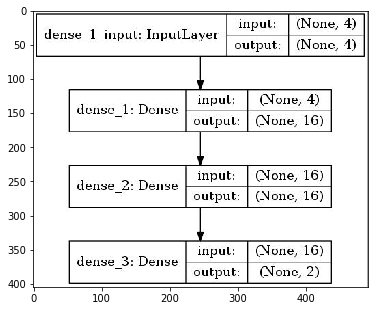

In [5]:
# 学習させるメインのQN
mainQN = DQN(
    state_size=num_state, 
    action_size=num_action, 
    hidden_size=num_hidden_unit, 
    learning_rate=learning_rate,
    gamma=gamma)

# 学習中に予測を行うQN（一つ前にエピソードのQN）
# Fixed Target Q-Network
# 少し前に固定しておいてQNを学習中の予測に使用する
targetQN = DQN(
    state_size=num_state, 
    action_size=num_action, 
    hidden_size=num_hidden_unit, 
    learning_rate=learning_rate,
    gamma=gamma)

mainQN.plot_model()

In [6]:
history = History(max_size=num_history)
rewards = []
rewards_goal_eval = np.zeros(num_goal_avg_episode)

for episode in range(num_max_episode):
    episode_reward = 0
    observation = env.reset()
    state = np.reshape(observation, [1, 4])
    targetQN = mainQN.clone_model() # 一つ前のエピソードのQN
    
    for step in range(num_max_step):
        action = get_action(state, episode, targetQN, is_learning=True)
        next_observation, reward, done, _ =  env.step(action)
        next_state = np.reshape(next_observation, [1, 4])
        
        # 各ステップで貰える報酬を-1, 0, 1で固定
        # clipping 
        # ゲーム内容によらず、同じハイパーパラメータのQNを使用できる
        if done: # 終了
            next_state = np.zeros(state.shape)
            if step < num_max_step-5:
                reward = -1 # 失敗
            else:
                reward = 1 # 成功
        else:
            reward = 0 # プレイ中
            
        episode_reward = episode_reward + 1
        
        history.add((state, action, reward, next_state))
        state = next_state
        
        if history.len() > num_batch: # バッチ数まで溜まった場合
            # 学習
            mainQN.replay_by_minibatch_sgd(history, num_batch, targetQN)
        
        # DQNモードなら最新のQNを使用させる
        if dqn_mode:
            targetQN = mainQN
            
        if done:
            rewards.append(episode_reward)
            rewards_goal_eval = np.hstack((rewards_goal_eval[1:], episode_reward))
            break
            
    # ゴール達成のため学習終了
    reward_avg = rewards_goal_eval.mean()
    print('episode: {}, episode_reward: {}'.format(episode, episode_reward))
    if reward_avg >= goal_avg_rewaed:
        print('learning finished: {}'.format(episode))
        break

episode: 0, episode_reward: 26
episode: 1, episode_reward: 12
episode: 2, episode_reward: 22
episode: 3, episode_reward: 12
episode: 4, episode_reward: 10
episode: 5, episode_reward: 8
episode: 6, episode_reward: 9
episode: 7, episode_reward: 11
episode: 8, episode_reward: 10
episode: 9, episode_reward: 10
episode: 10, episode_reward: 10
episode: 11, episode_reward: 9
episode: 12, episode_reward: 12
episode: 13, episode_reward: 16
episode: 14, episode_reward: 13
episode: 15, episode_reward: 21
episode: 16, episode_reward: 15
episode: 17, episode_reward: 16
episode: 18, episode_reward: 11
episode: 19, episode_reward: 13
episode: 20, episode_reward: 14
episode: 21, episode_reward: 12
episode: 22, episode_reward: 14
episode: 23, episode_reward: 15
episode: 24, episode_reward: 16
episode: 25, episode_reward: 12
episode: 26, episode_reward: 14
episode: 27, episode_reward: 15
episode: 28, episode_reward: 12
episode: 29, episode_reward: 13
episode: 30, episode_reward: 13
episode: 31, episode_

### 学習後のQNでシュミレーション


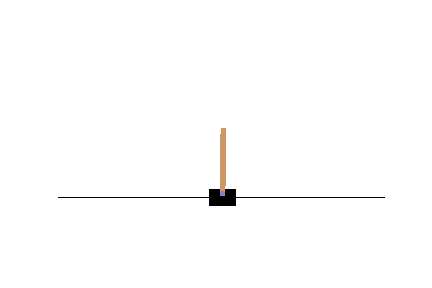
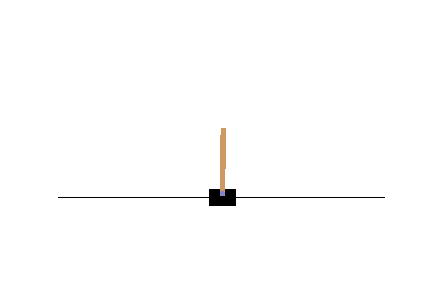
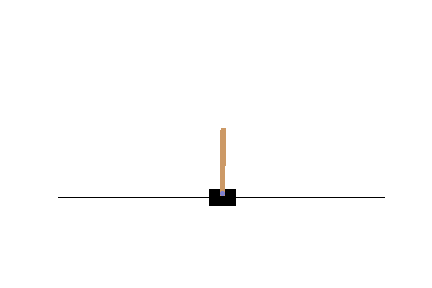
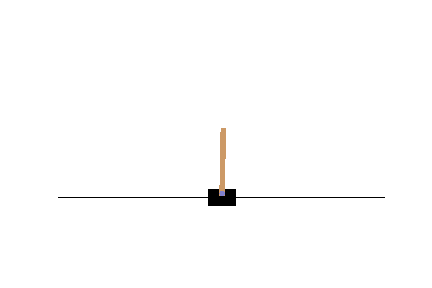
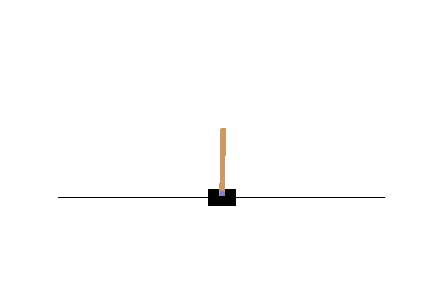
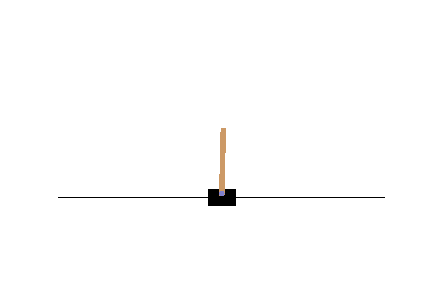
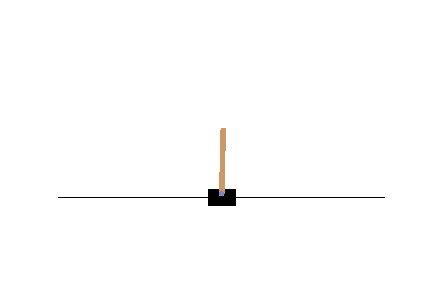
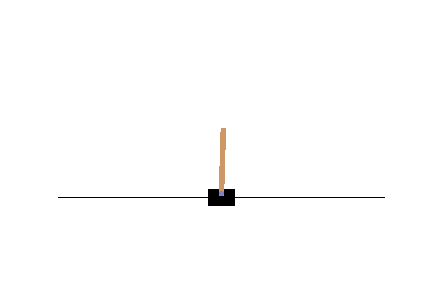
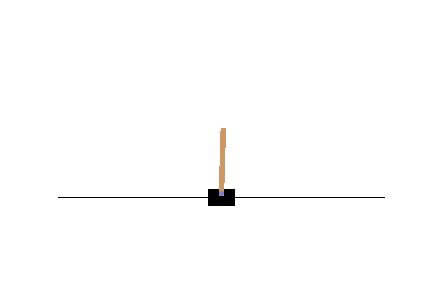
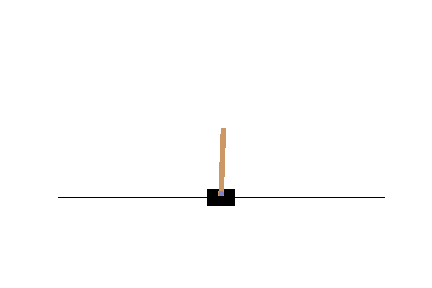
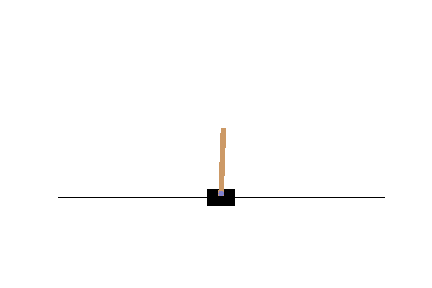
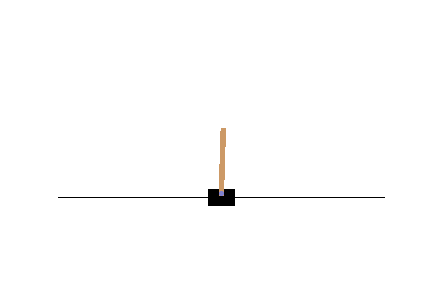
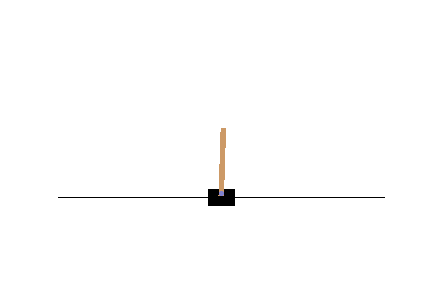
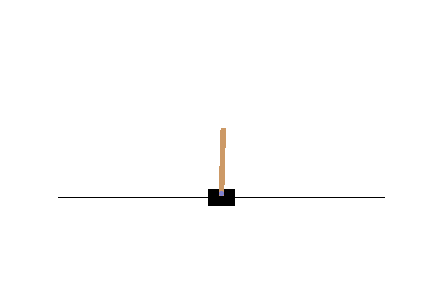
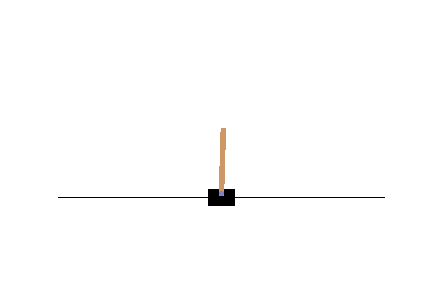
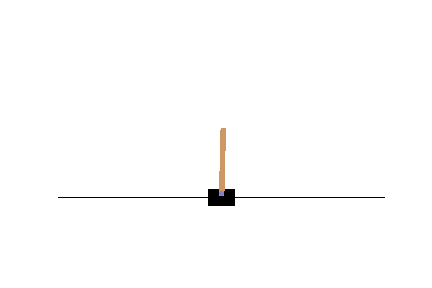
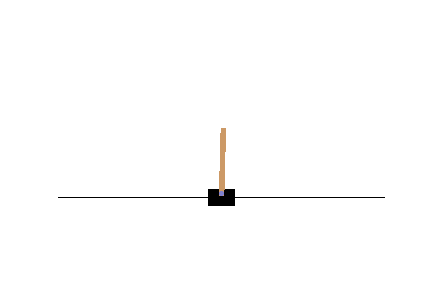
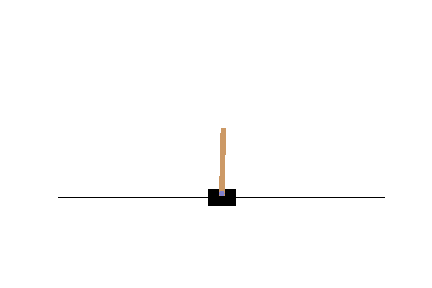
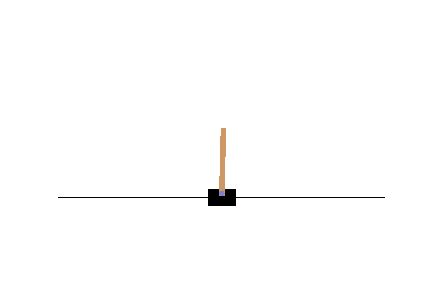
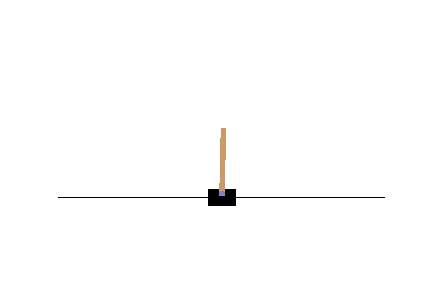
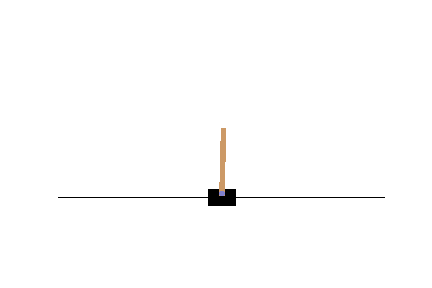
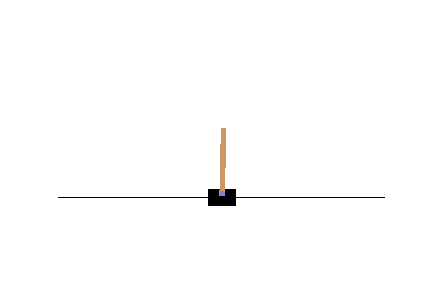
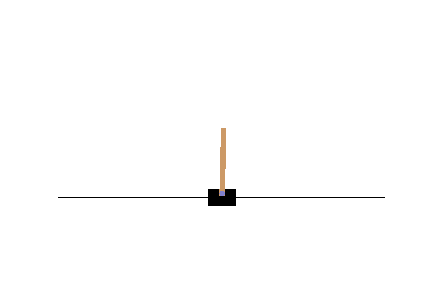
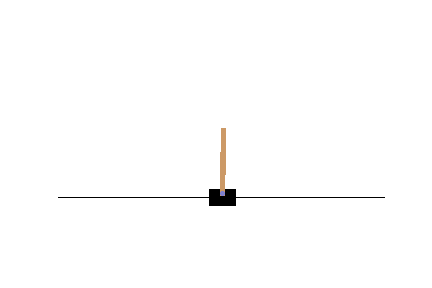
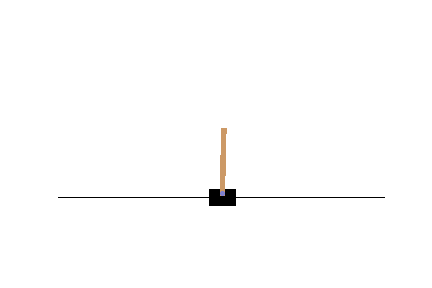
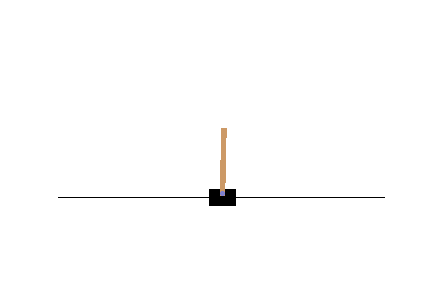
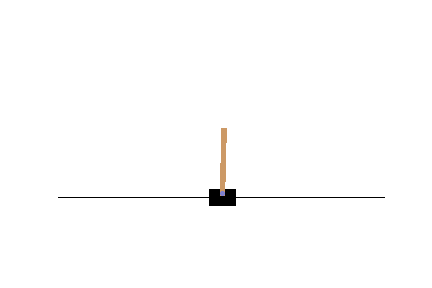
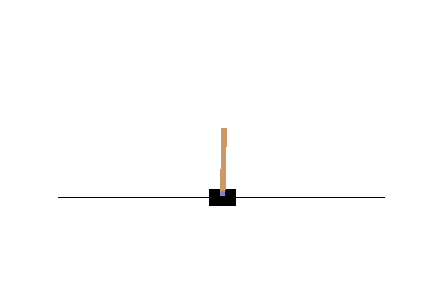
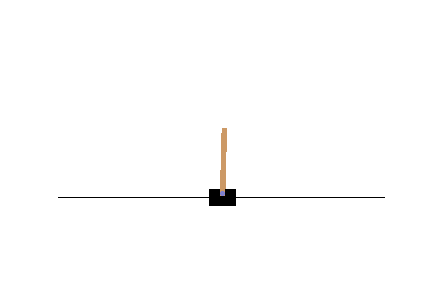
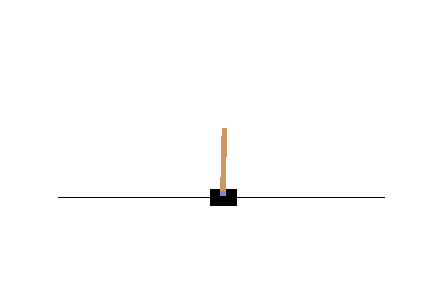
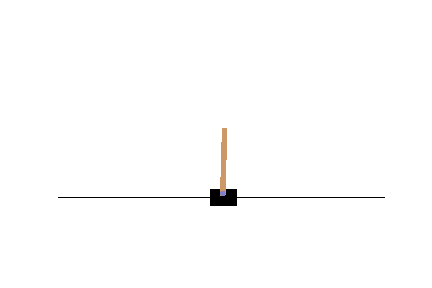
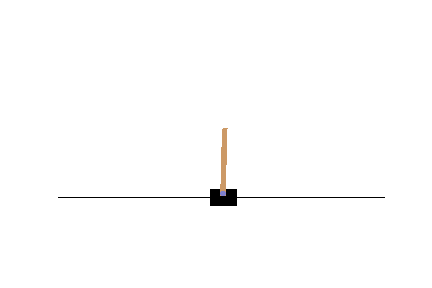
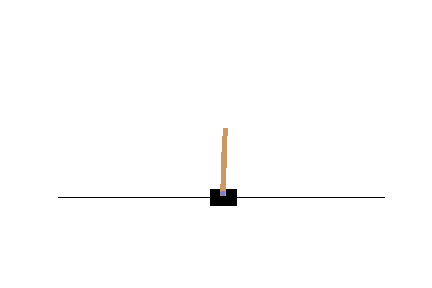
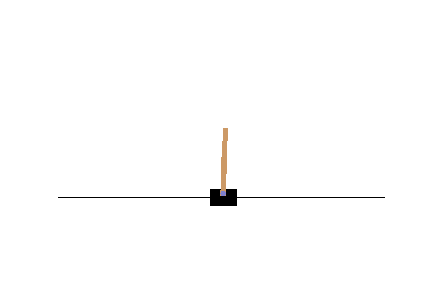
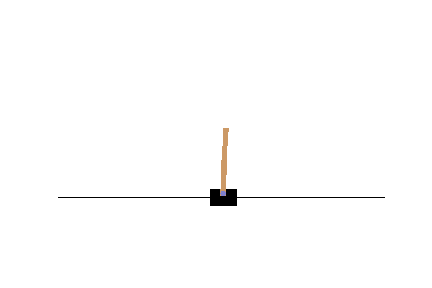
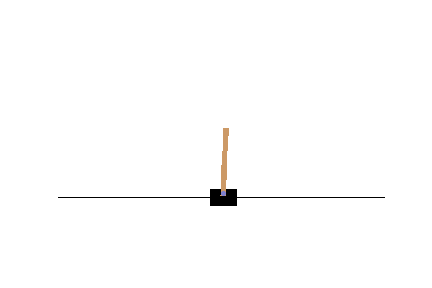
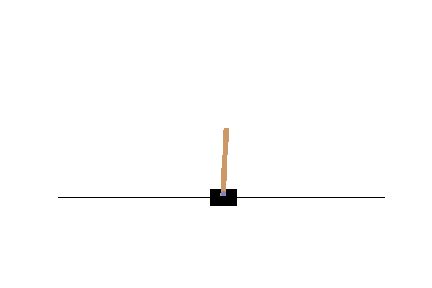
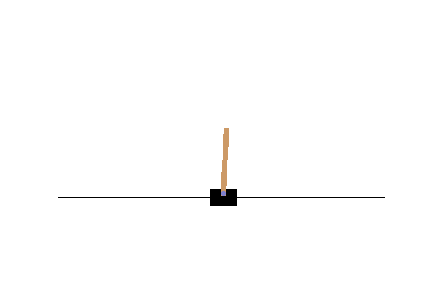
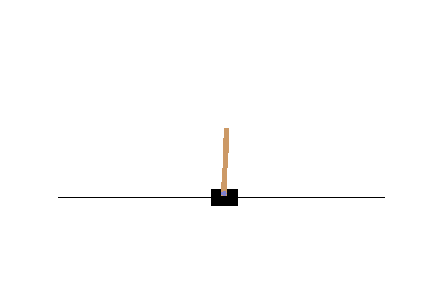
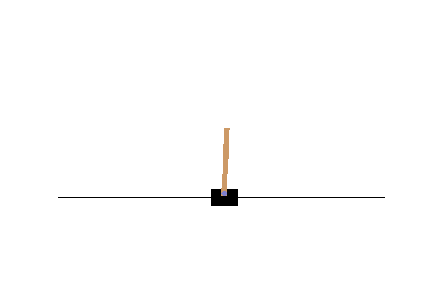
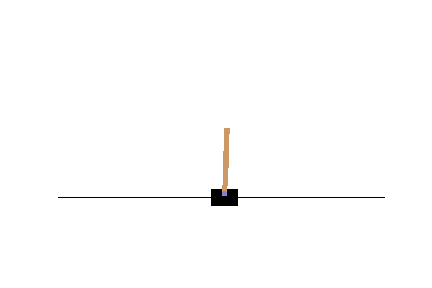
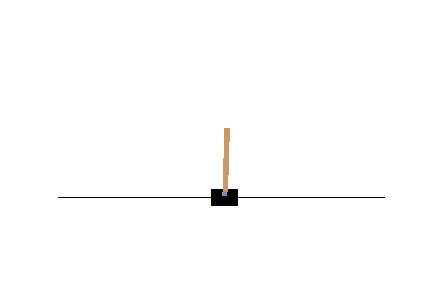
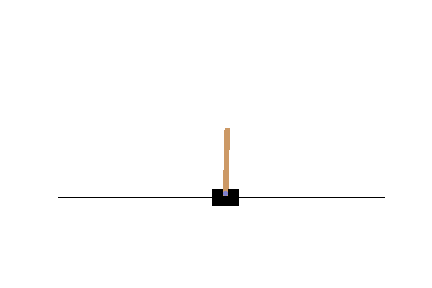
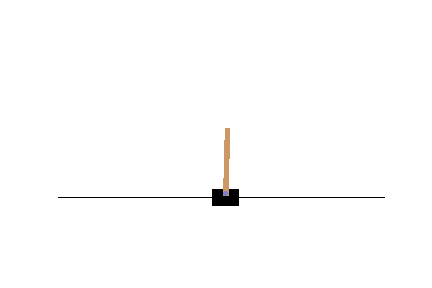
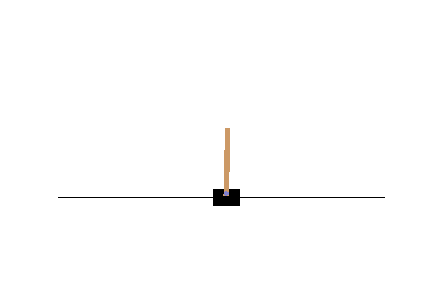
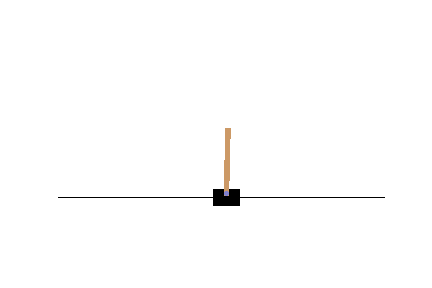
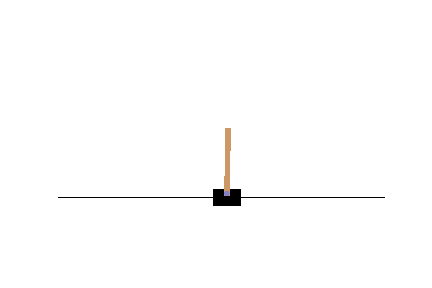
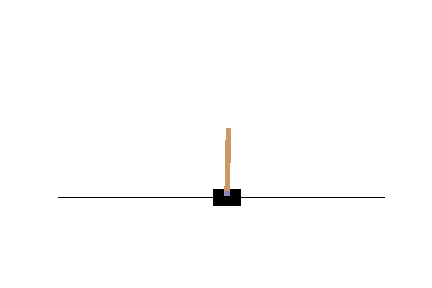
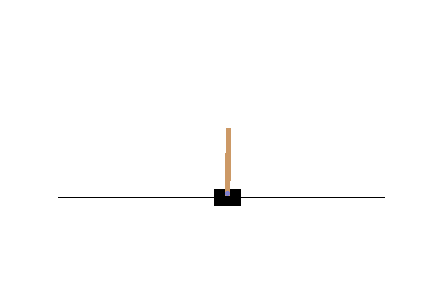
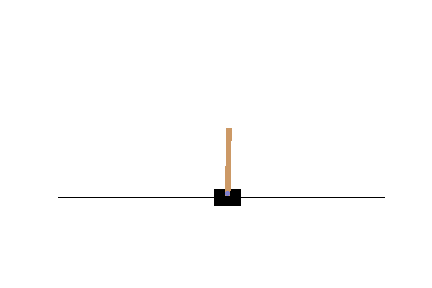
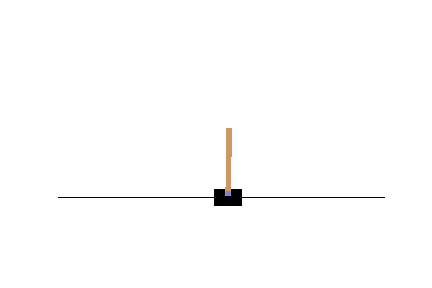
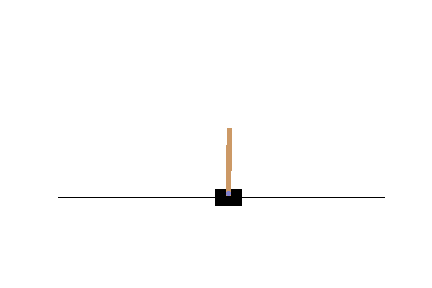
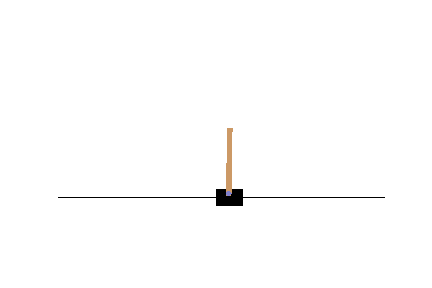
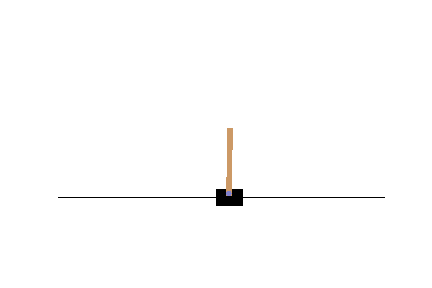
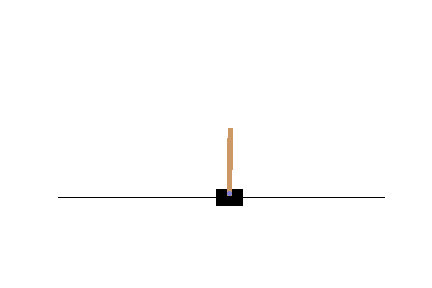
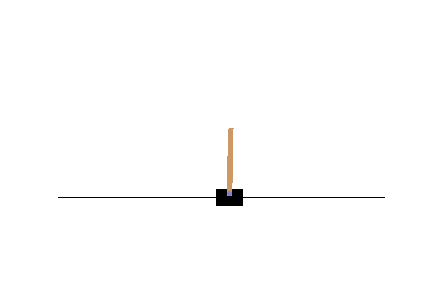
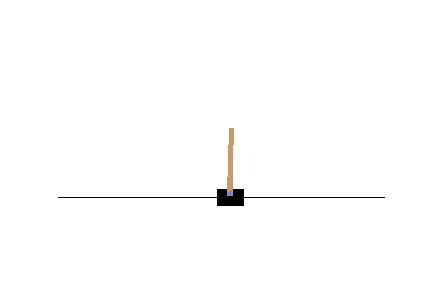
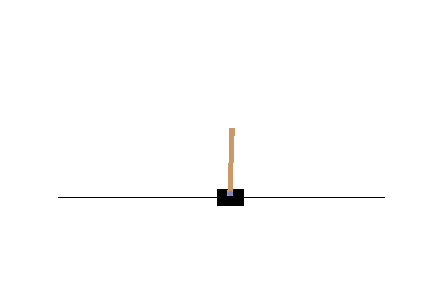
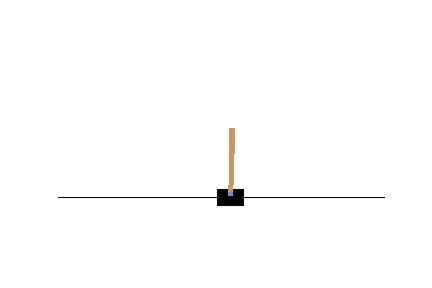
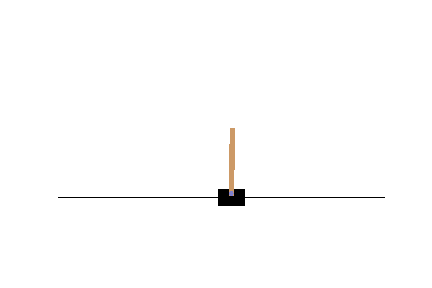
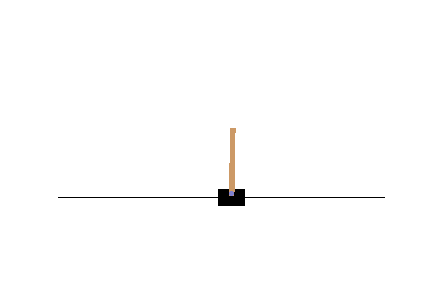
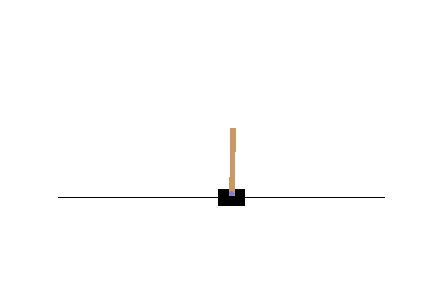
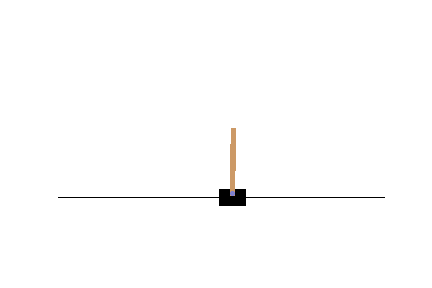
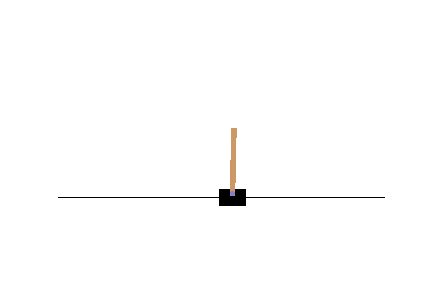
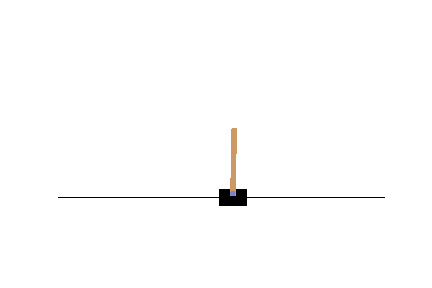
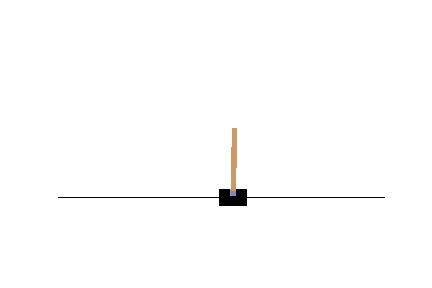
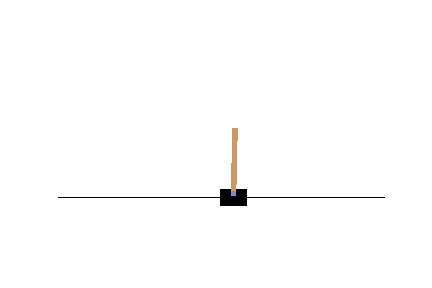
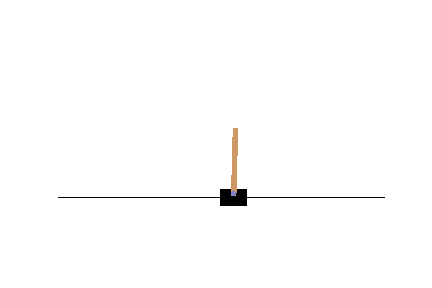
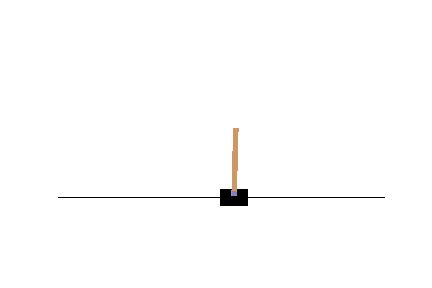
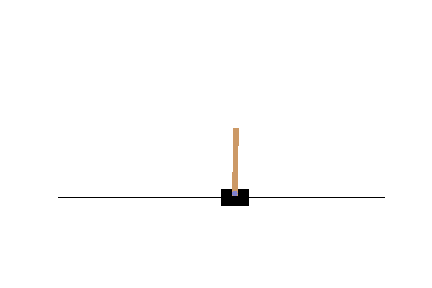
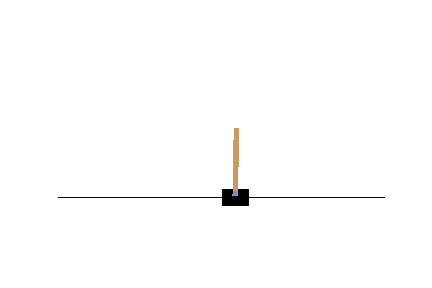
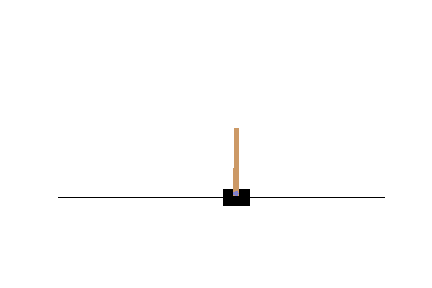
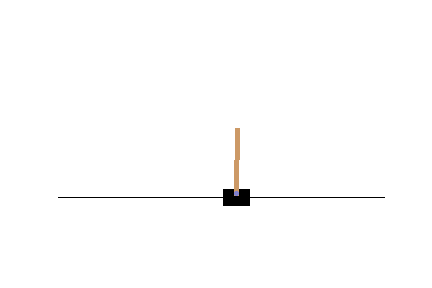
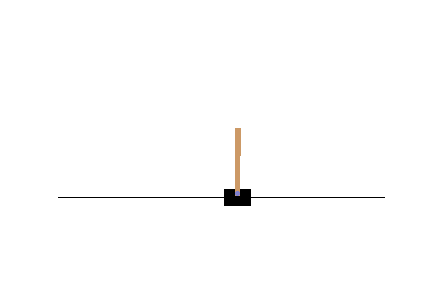
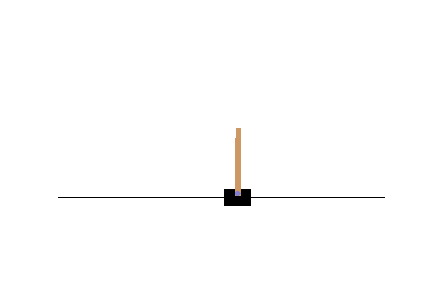
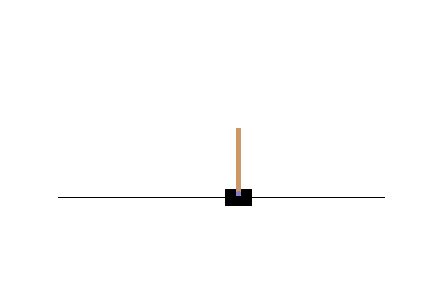
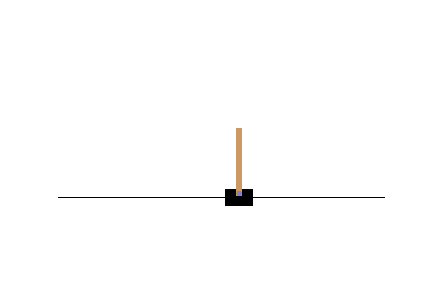
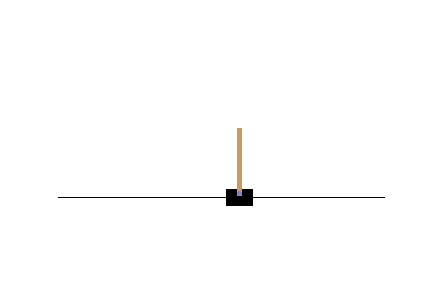
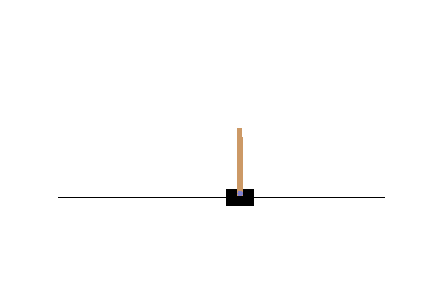
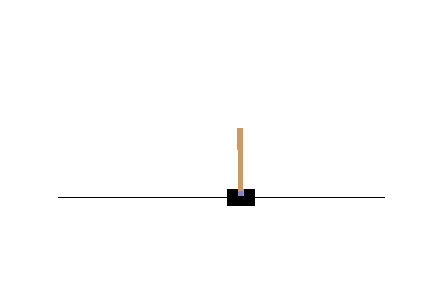
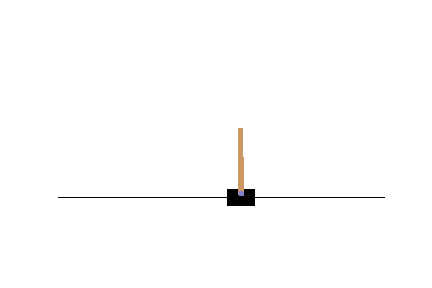
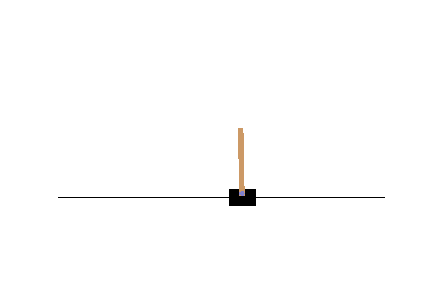
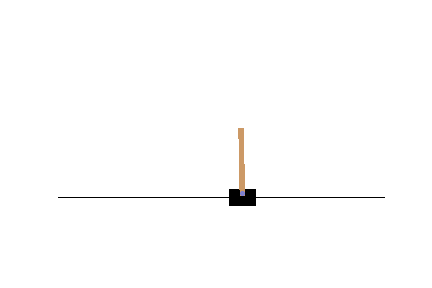
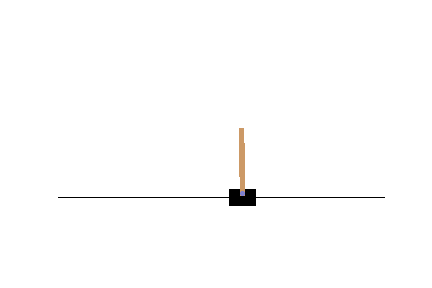
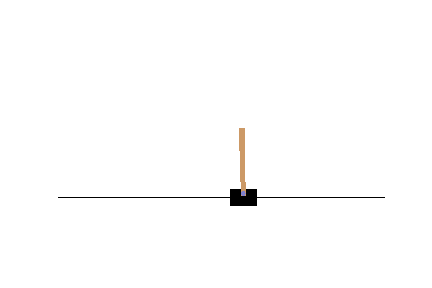
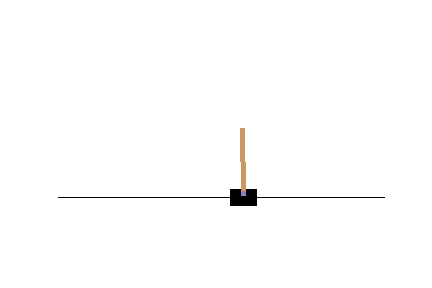
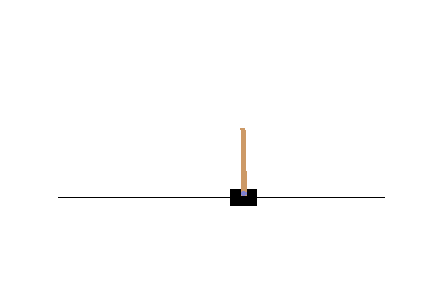
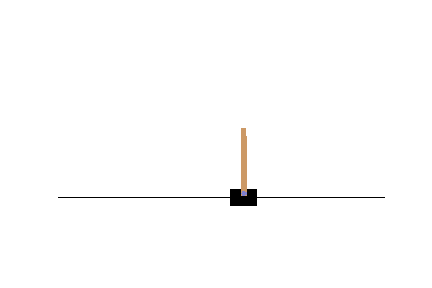
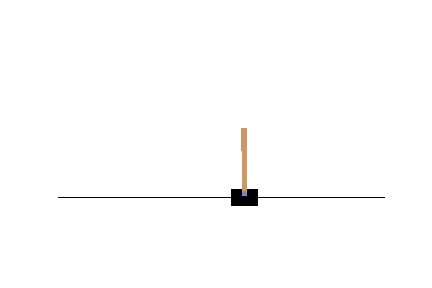
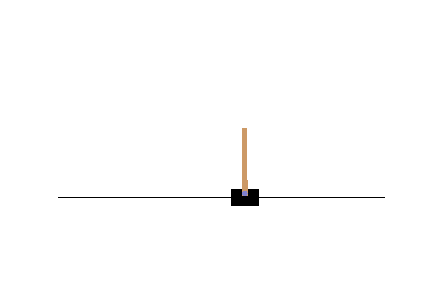
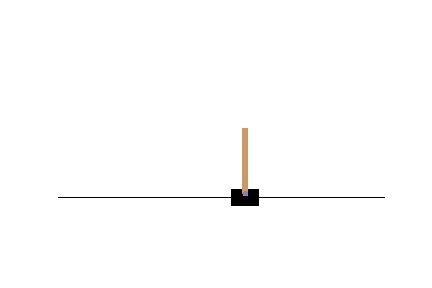
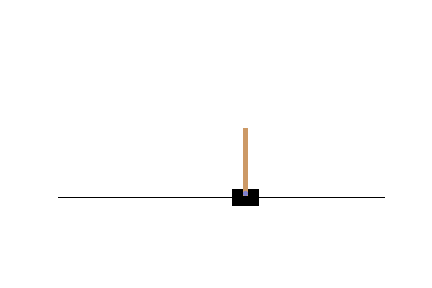
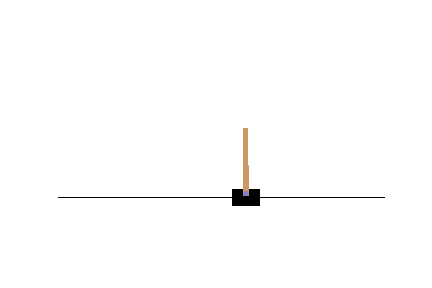
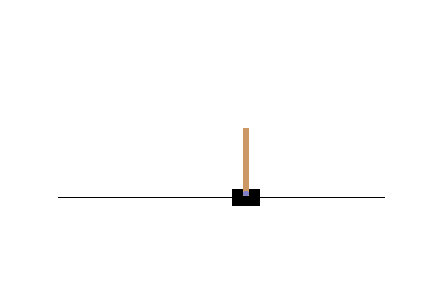
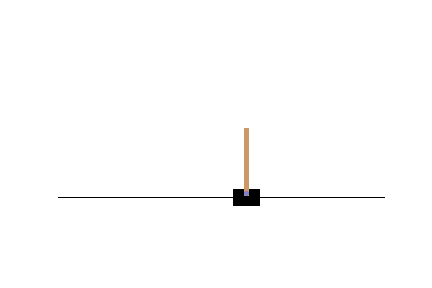
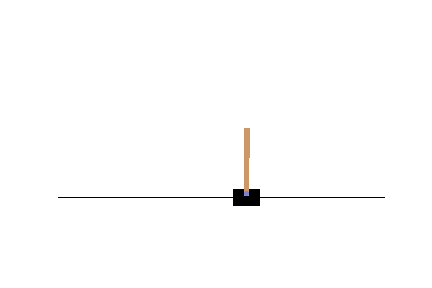
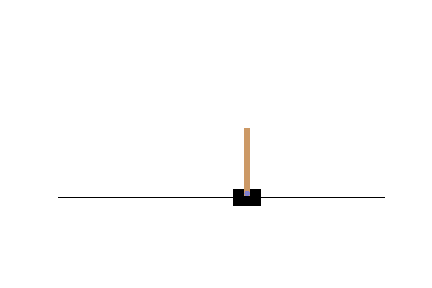
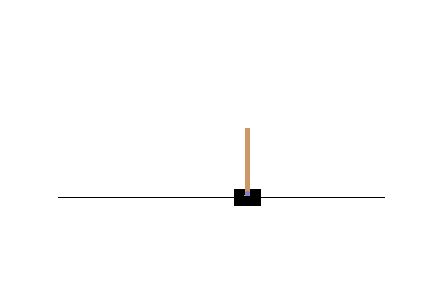
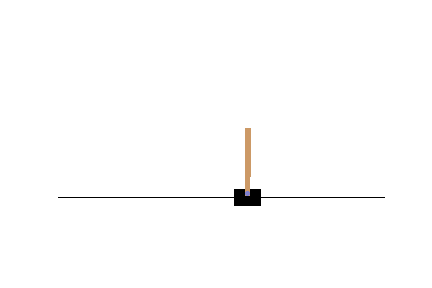
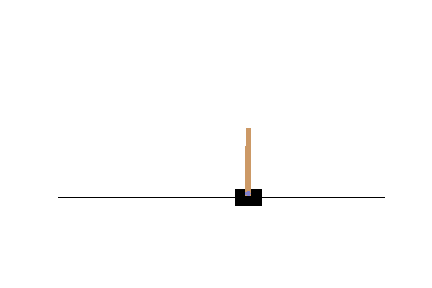
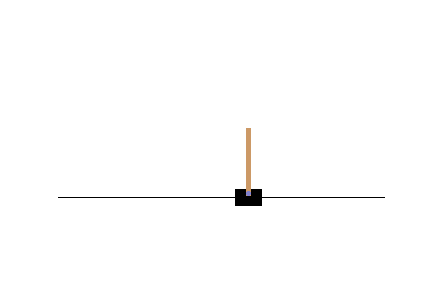
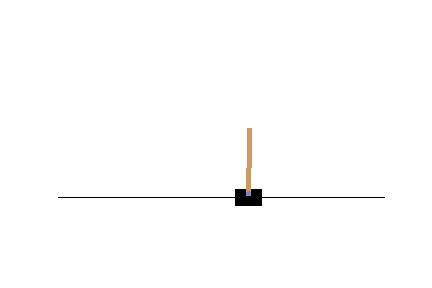
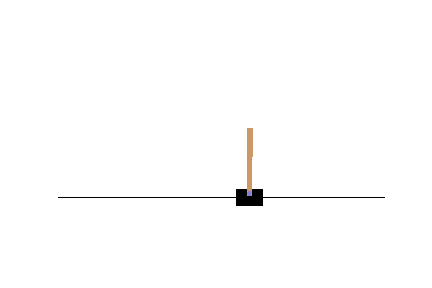
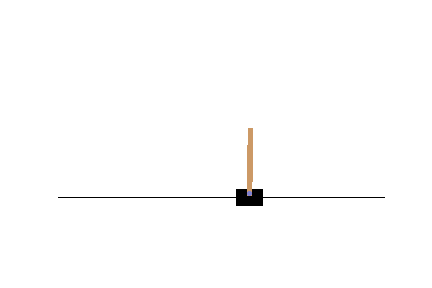
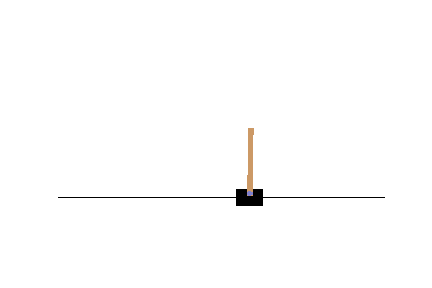
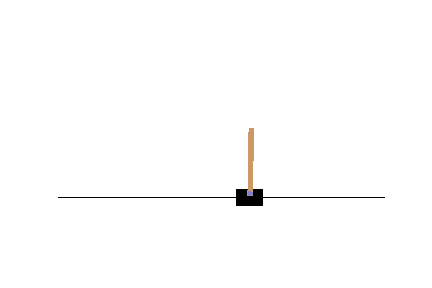
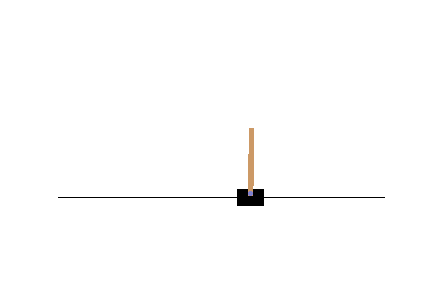
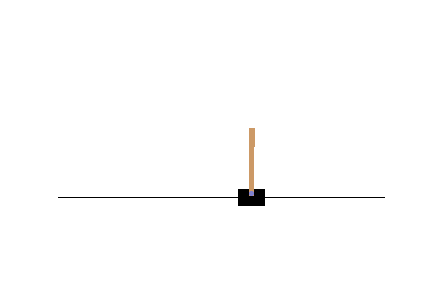
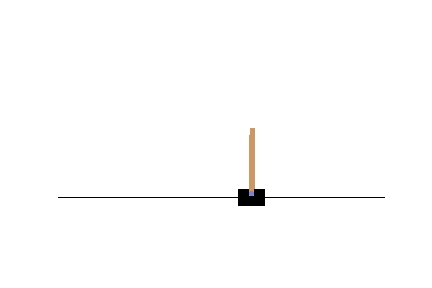
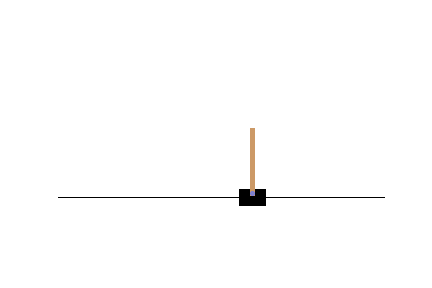
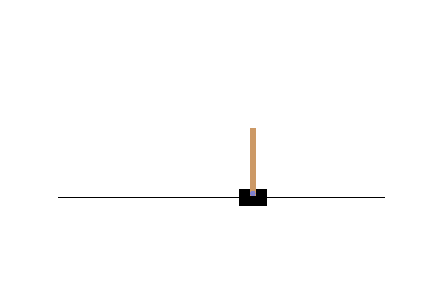
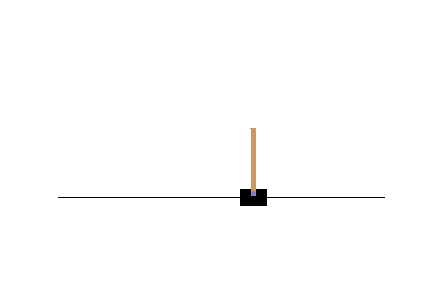
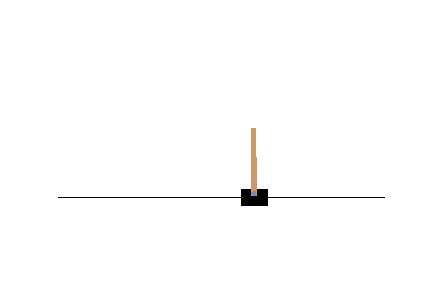
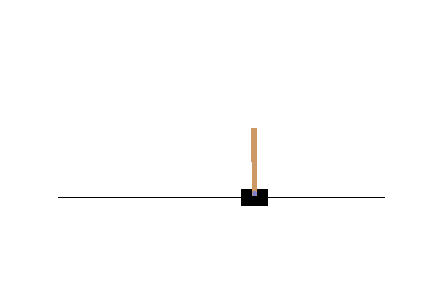
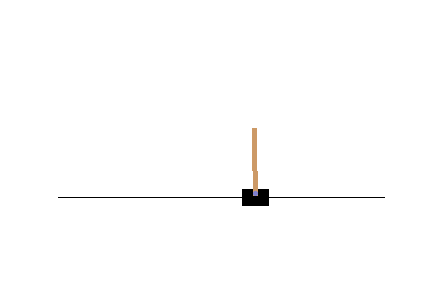
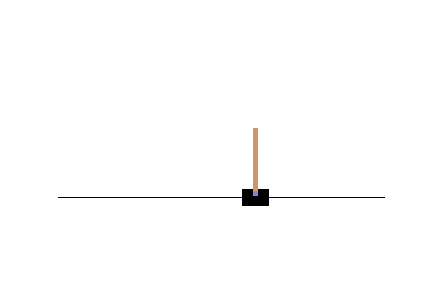
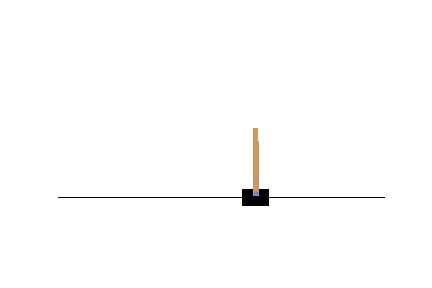
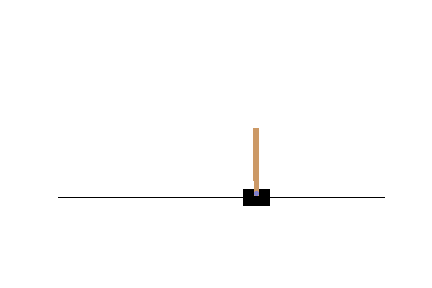
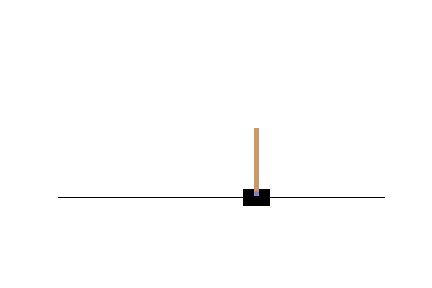
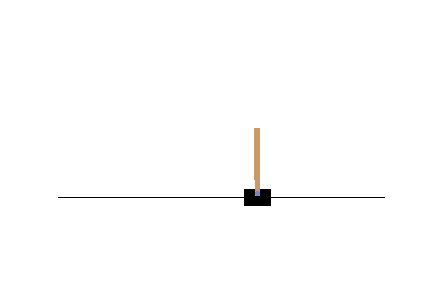
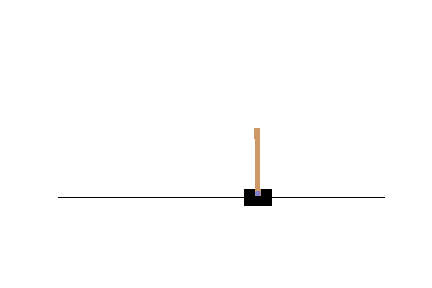
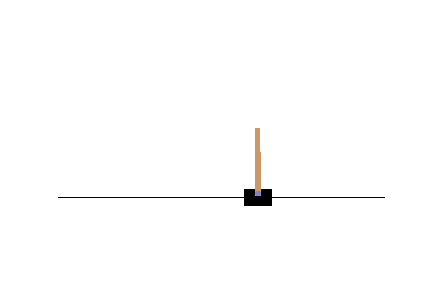
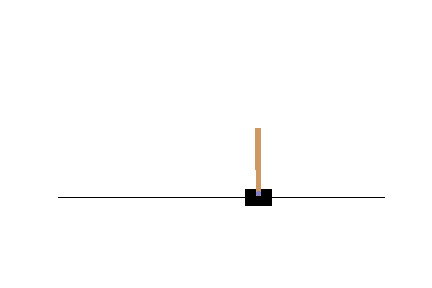
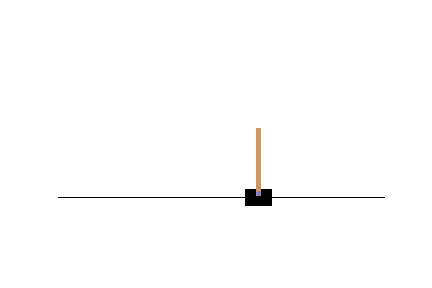
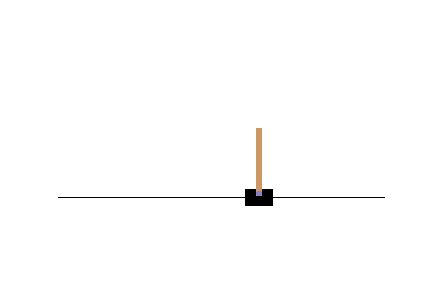
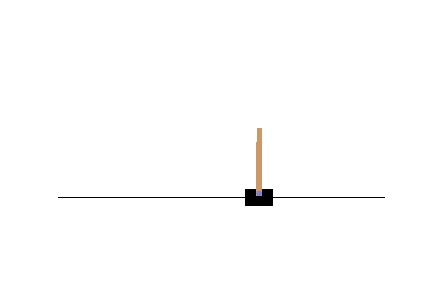
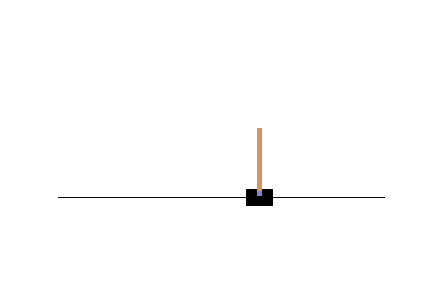
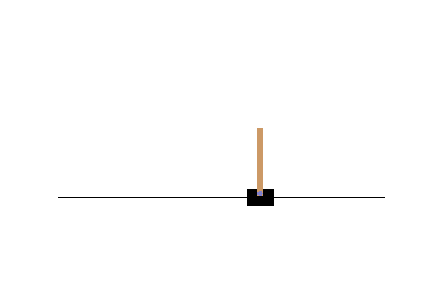
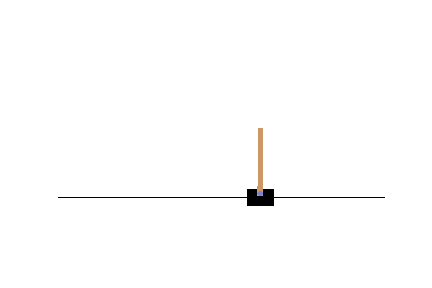
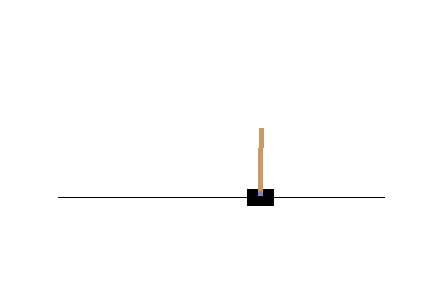
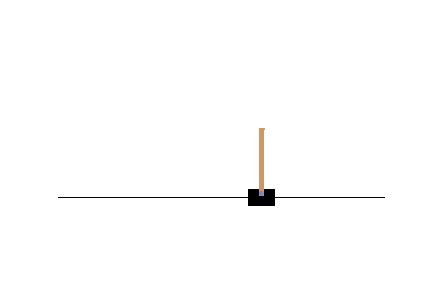
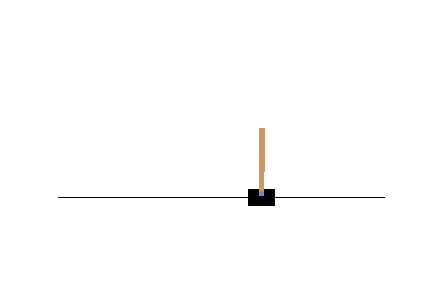
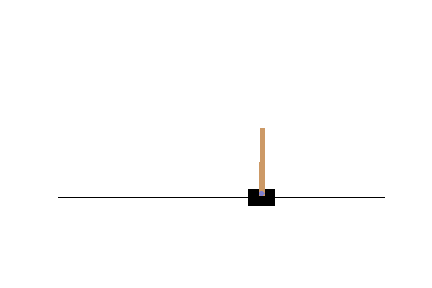
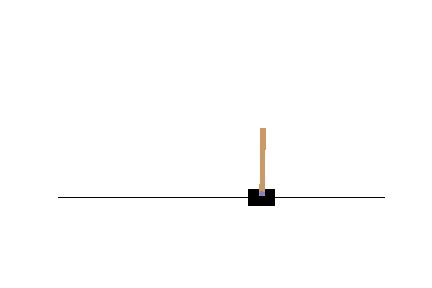
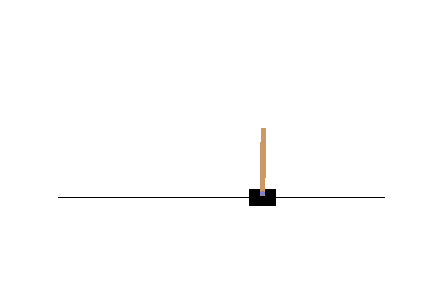
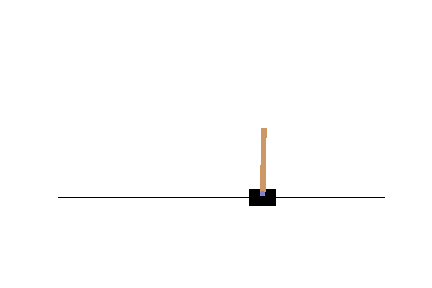
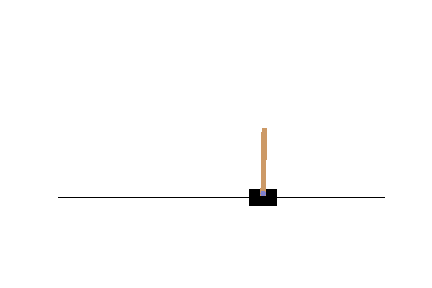
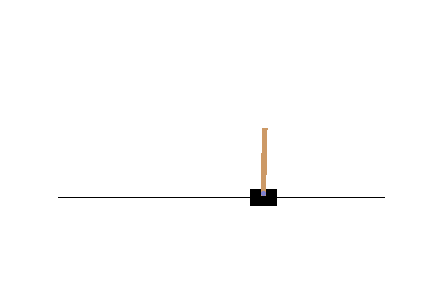
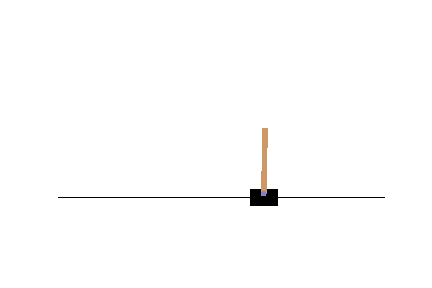
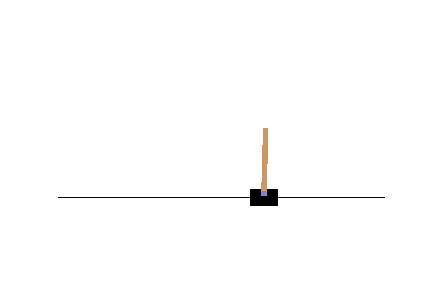
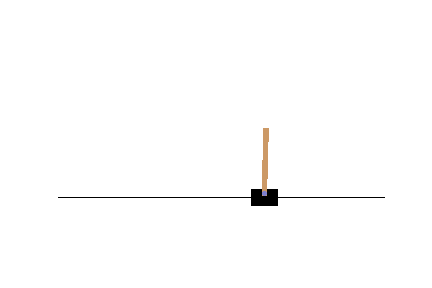
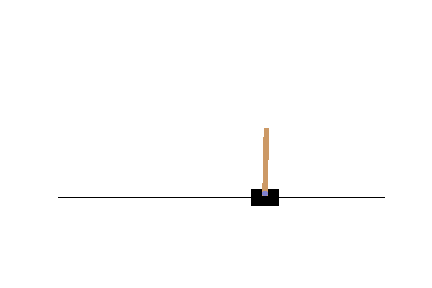
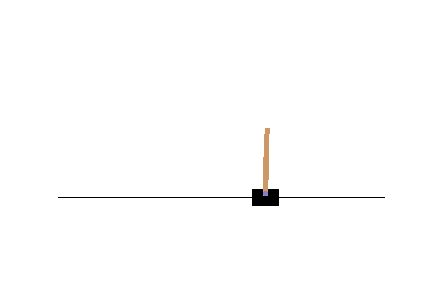
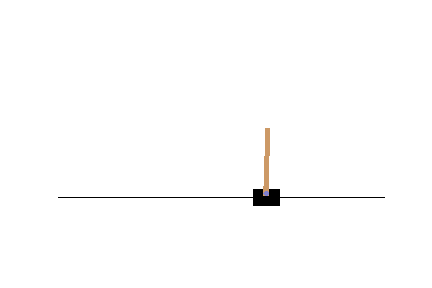
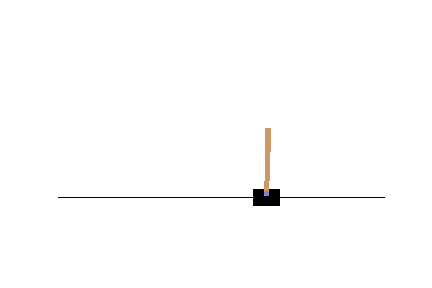
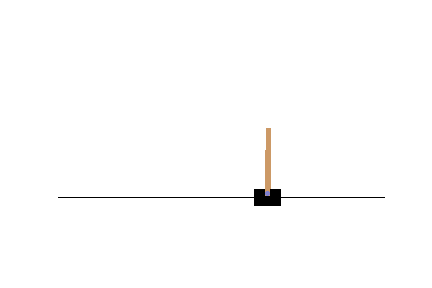
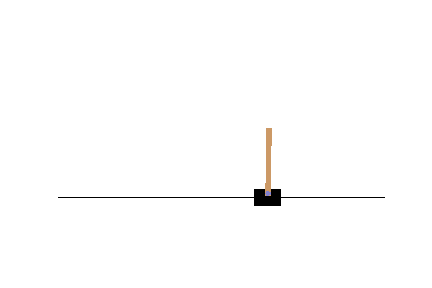
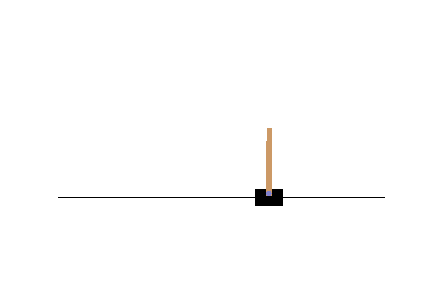
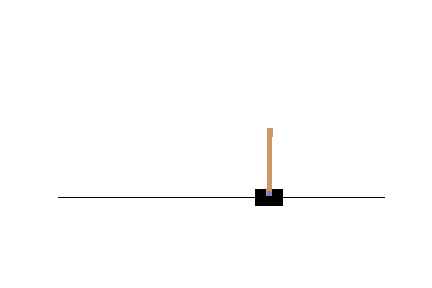
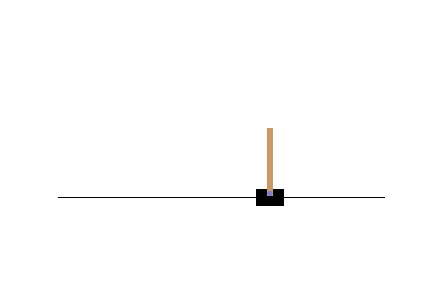
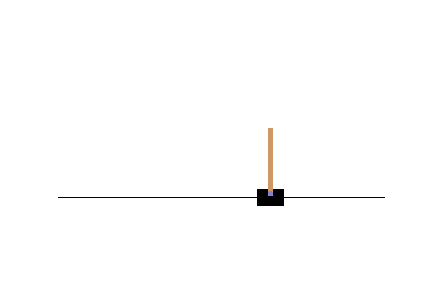
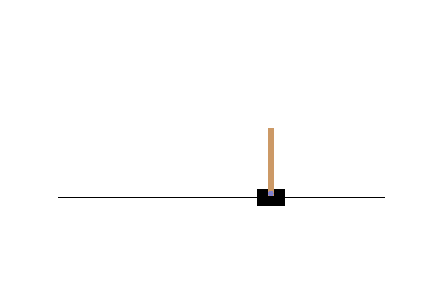
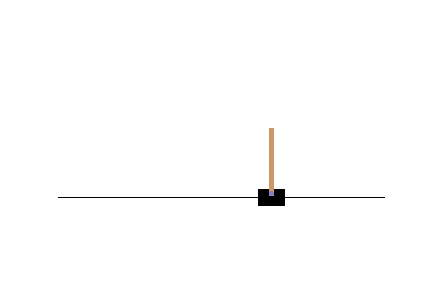
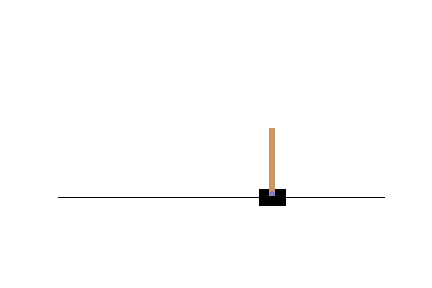
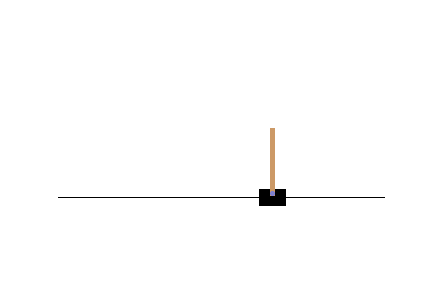
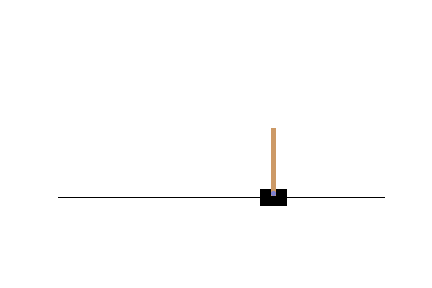
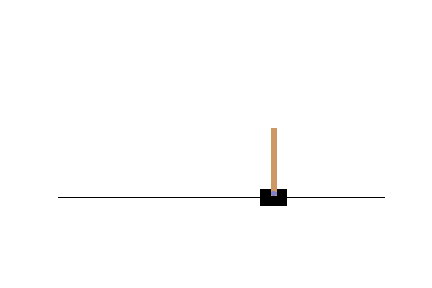
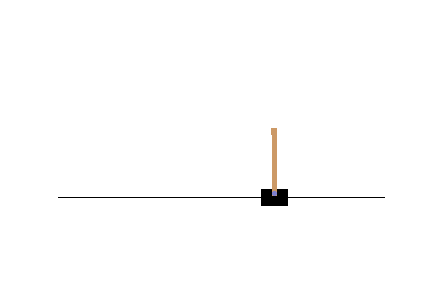
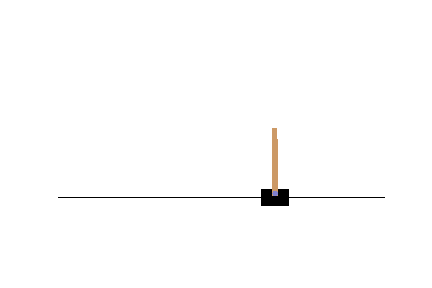
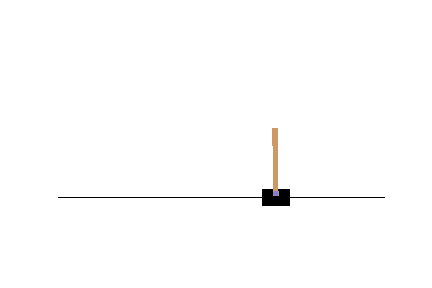
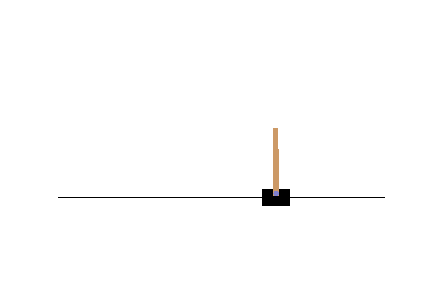
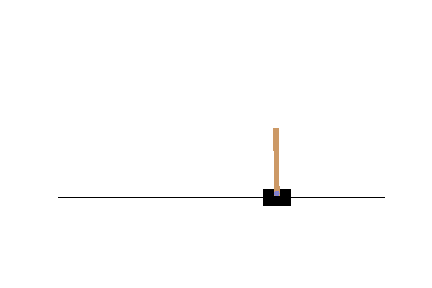
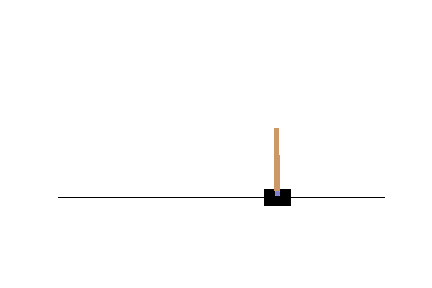
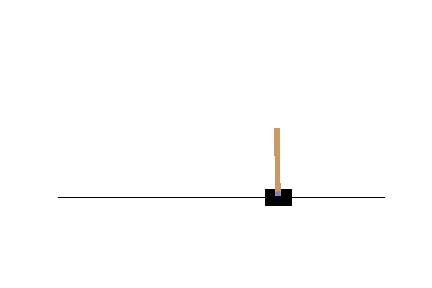
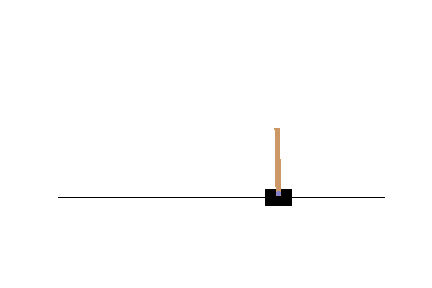
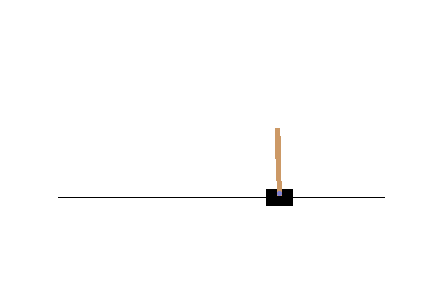
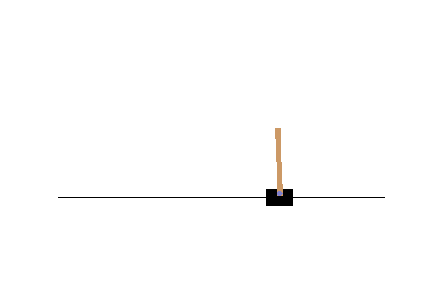
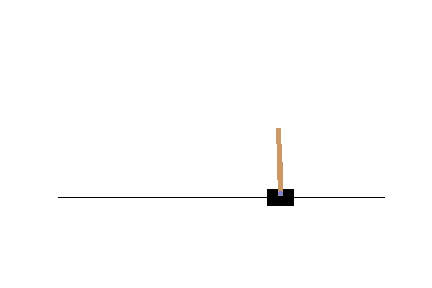
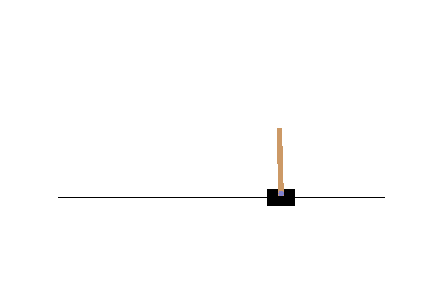
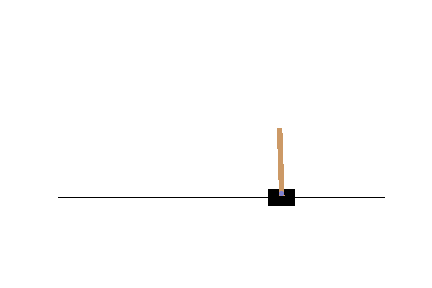
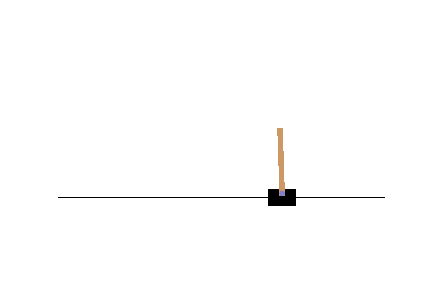
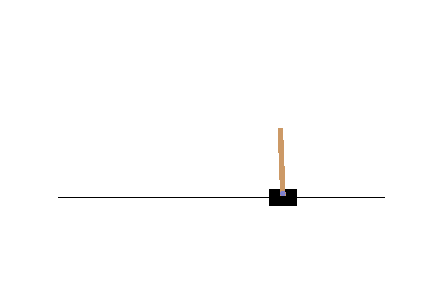
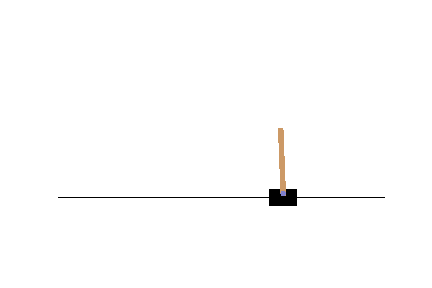
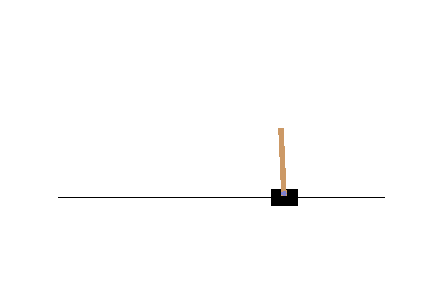
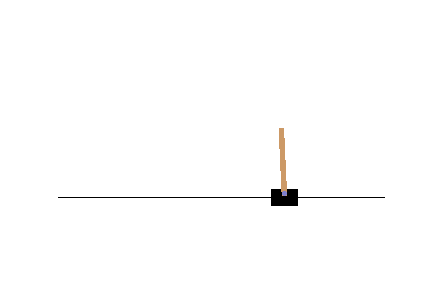
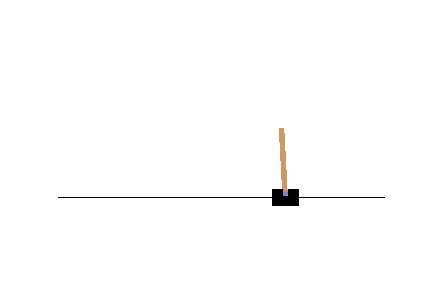
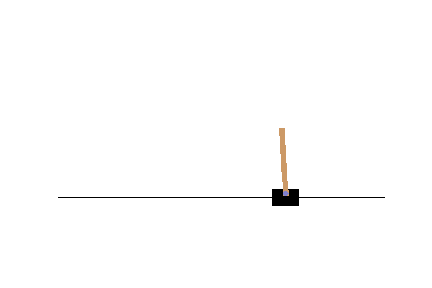
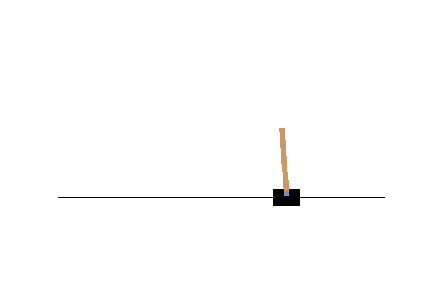
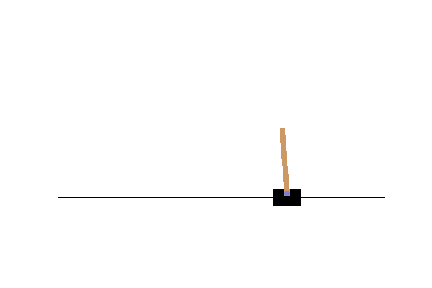
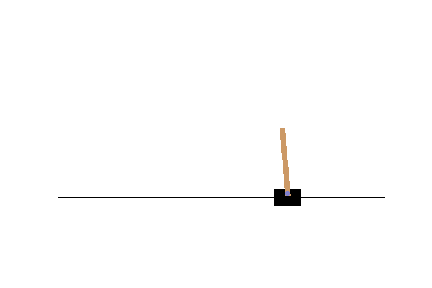
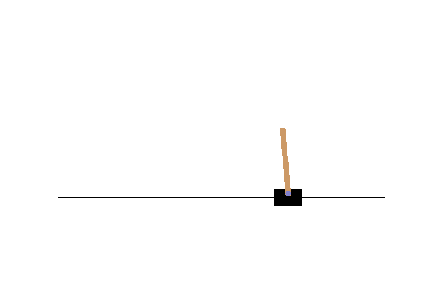
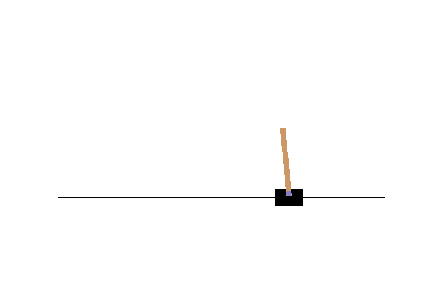
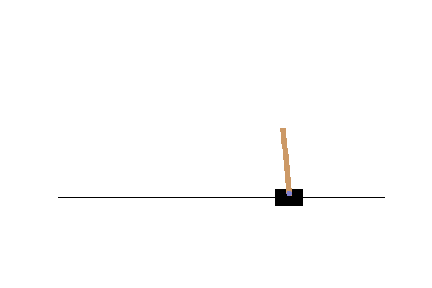
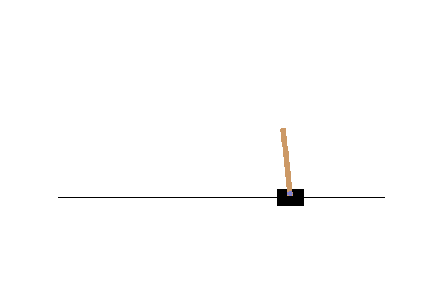
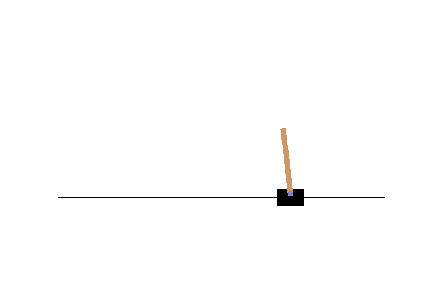
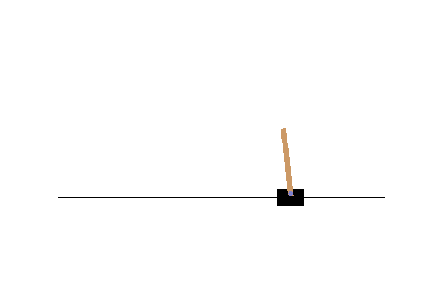
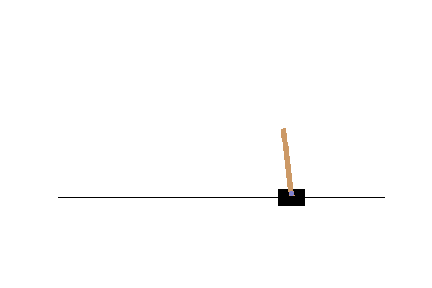
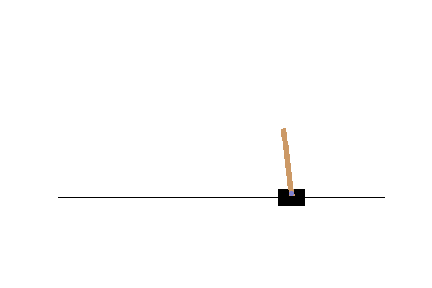
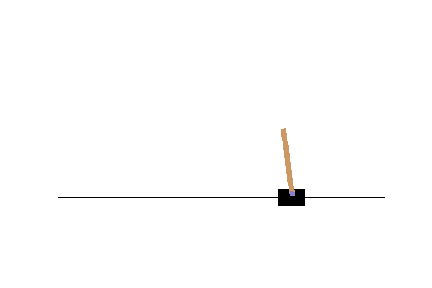
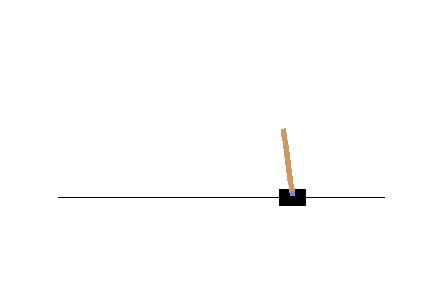
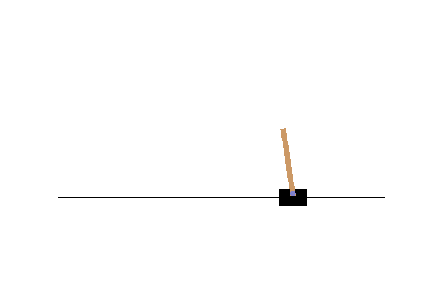
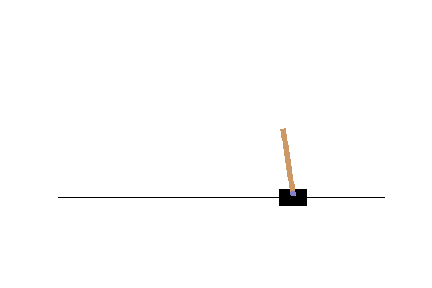
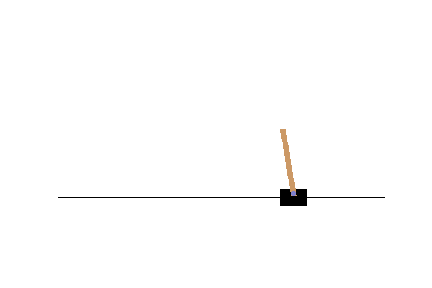
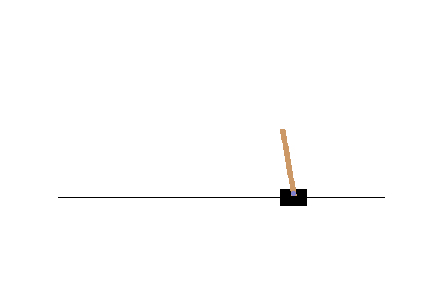
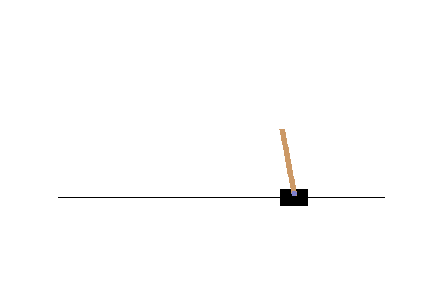
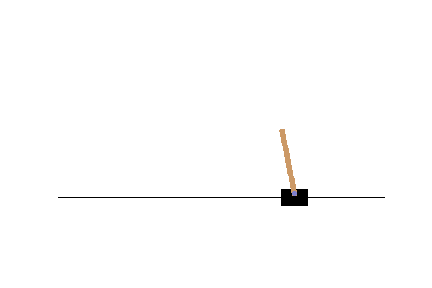
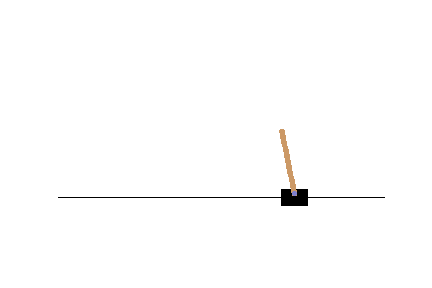
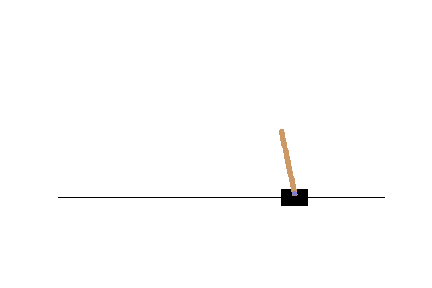
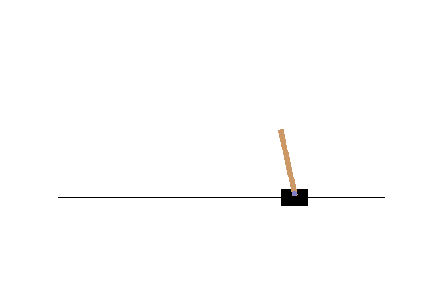

In [7]:
observation = env.reset()

frames = []
for episode in range(num_max_step):
    state = np.reshape(observation, [1, 4])
    action = get_action(state, episode, mainQN,  is_learning=False)
    observation, reward, done, _ =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

## Prioritized Experience Replay DQNで学習

In [8]:
# 学習させるメインのQN
mainQN = DQN(
    state_size=num_state, 
    action_size=num_action, 
    hidden_size=num_hidden_unit, 
    learning_rate=learning_rate,
    gamma=gamma)

# 学習中に予測を行うQN（一つ前にエピソードのQN）
targetQN = DQN(
    state_size=num_state, 
    action_size=num_action, 
    hidden_size=num_hidden_unit, 
    learning_rate=learning_rate,
    gamma=gamma)

history = History(max_size=num_history)
history_tderror = HistoryTDerror(max_size=num_history)

rewards_per = []
rewards_goal_eval = np.zeros(num_goal_avg_episode)

for episode in range(num_max_episode):
    episode_reward = 0
    observation = env.reset()
    state = np.reshape(observation, [1, 4])
    
    for step in range(num_max_step):
        action = get_action(state, episode, targetQN, is_learning=True)
        next_observation, reward, done, _ =  env.step(action)
        next_state = np.reshape(next_observation, [1, 4])
        
        # 各ステップで貰える報酬を-1, 0, 1で固定
        # clipping 
        # ゲーム内容によらず、同じハイパーパラメータのQNを使用できる
        if done: # 終了
            next_state = np.zeros(state.shape)
            if step < num_max_step-5:
                reward = -1 # 失敗
            else:
                reward = 1 # 成功
        else:
            reward = 0 # プレイ中
            
        episode_reward = episode_reward + 1
        
        history.add((state, action, reward, next_state))
        history_tderror.add(mainQN.get_tderror(state, action, reward, next_state, targetQN))
        
        state = next_state
        
        if history.len() > num_batch: # バッチ数まで溜まった場合
            if rewards_goal_eval.mean() < 20:
                mainQN.replay_by_minibatch_sgd(history, num_batch, targetQN)
            else:
                mainQN.replay_by_pioritized_experience(history, history_tderror, num_batch, targetQN)
                
        # DQNモードなら最新のQNを使用させる
        if dqn_mode:
            targetQN = mainQN
            
        if done:
            targetQN = mainQN.clone_model() # 一つ前のエピソードのQN
            history_tderror.update_tderror(history, mainQN, targetQN)
            rewards_per.append(episode_reward)
            rewards_goal_eval = np.hstack((rewards_goal_eval[1:], episode_reward))
            break
            
    # ゴール達成のため学習終了
    reward_avg = rewards_goal_eval.mean()
    print('episode: {}, episode_reward: {}'.format(episode, episode_reward))
    if reward_avg >= goal_avg_rewaed:
        print('learning finished: {}'.format(episode))
        break

episode: 0, episode_reward: 30
episode: 1, episode_reward: 10
episode: 2, episode_reward: 8
episode: 3, episode_reward: 9
episode: 4, episode_reward: 10
episode: 5, episode_reward: 19
episode: 6, episode_reward: 8
episode: 7, episode_reward: 10
episode: 8, episode_reward: 31
episode: 9, episode_reward: 43
episode: 10, episode_reward: 37
episode: 11, episode_reward: 65
episode: 12, episode_reward: 26
episode: 13, episode_reward: 30
episode: 14, episode_reward: 46
episode: 15, episode_reward: 39
episode: 16, episode_reward: 43
episode: 17, episode_reward: 97
episode: 18, episode_reward: 37
episode: 19, episode_reward: 81
episode: 20, episode_reward: 35
episode: 21, episode_reward: 37
episode: 22, episode_reward: 48
episode: 23, episode_reward: 24
episode: 24, episode_reward: 41
episode: 25, episode_reward: 24
episode: 26, episode_reward: 152
episode: 27, episode_reward: 30
episode: 28, episode_reward: 52
episode: 29, episode_reward: 31
episode: 30, episode_reward: 29
episode: 31, episode

### 学習後のQNでシュミレーション


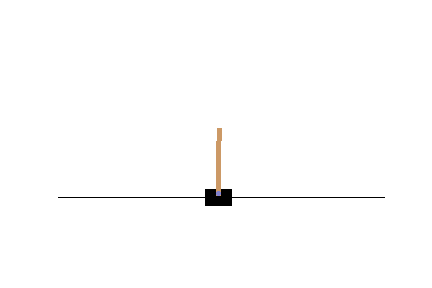
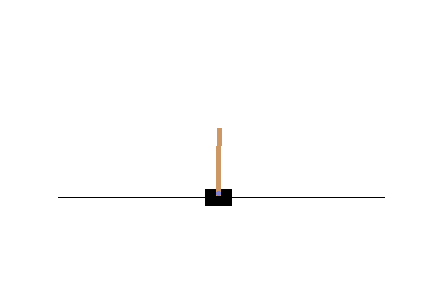
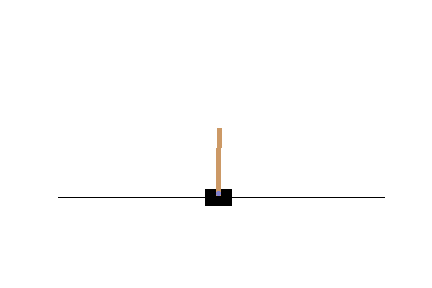
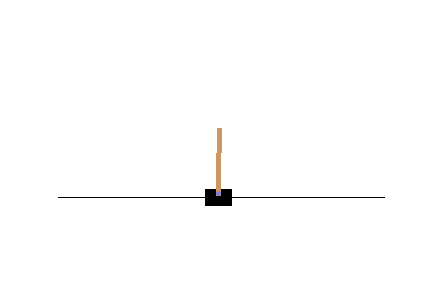
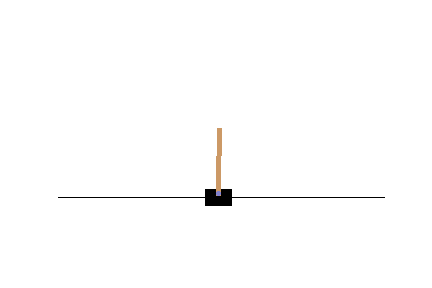
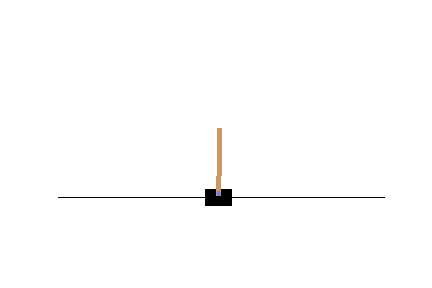
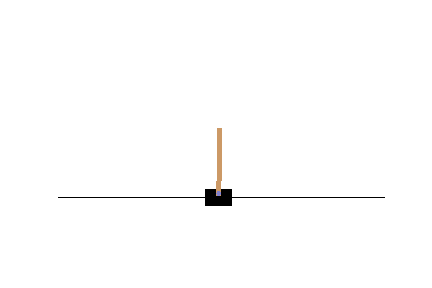
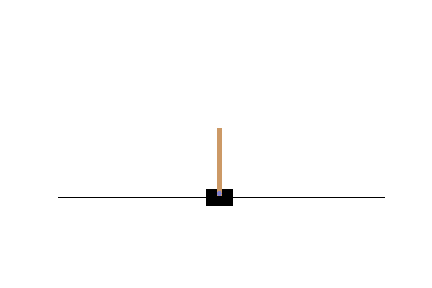
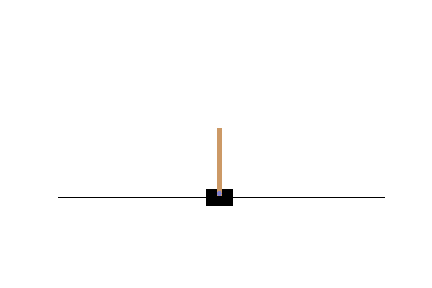
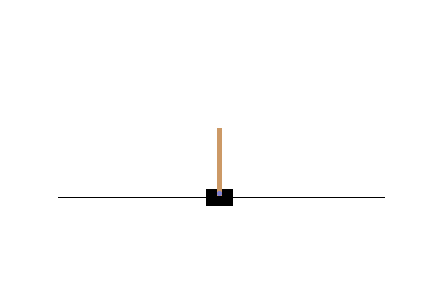
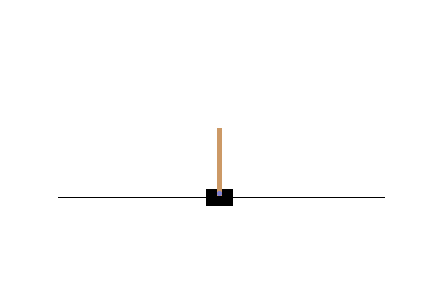
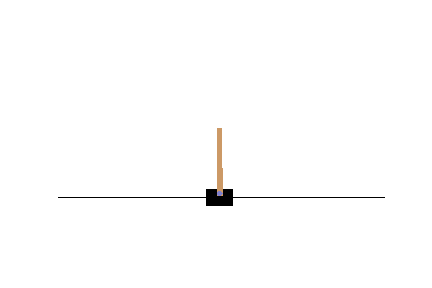
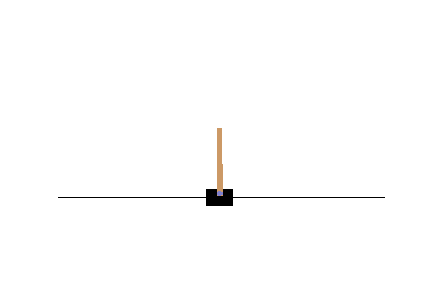
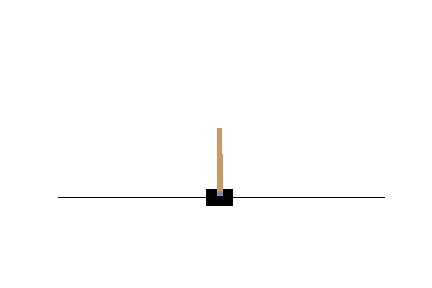
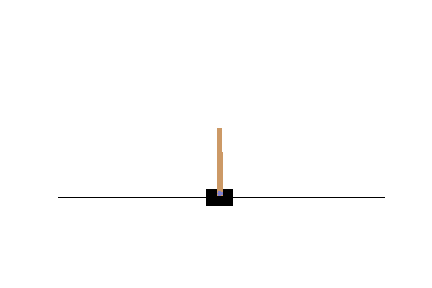
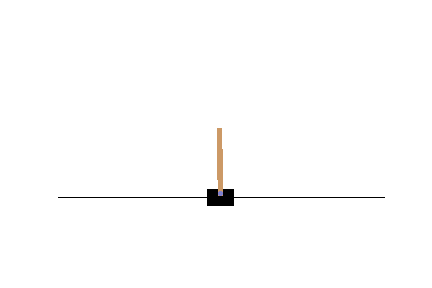
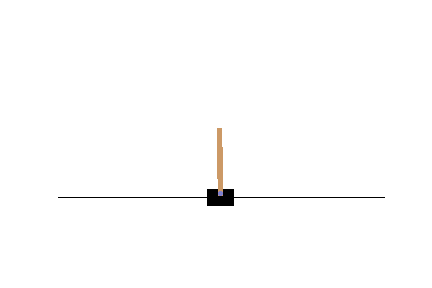
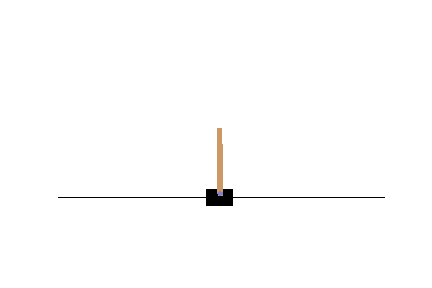
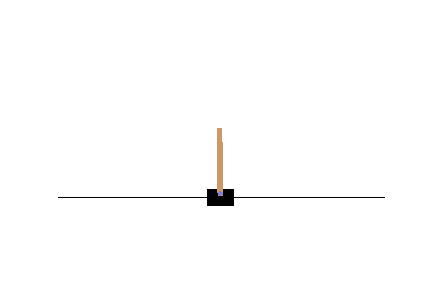
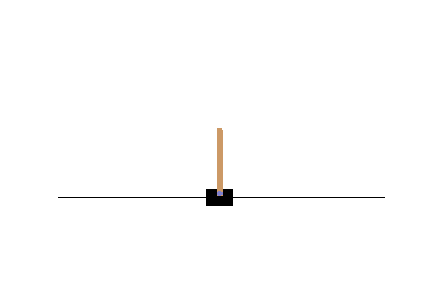
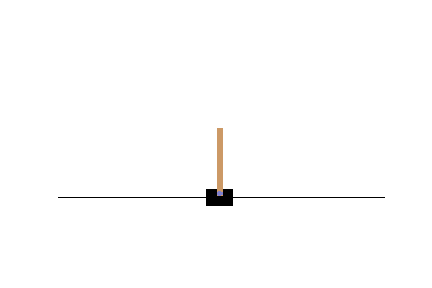
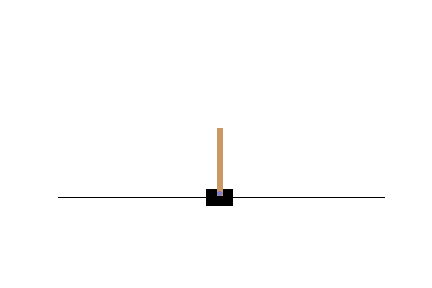
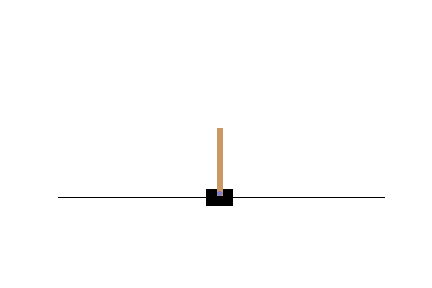
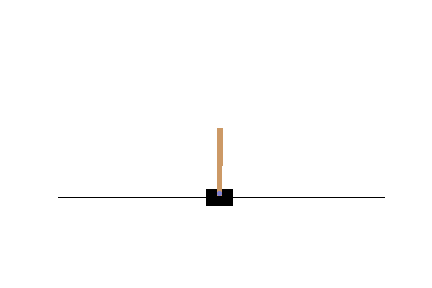
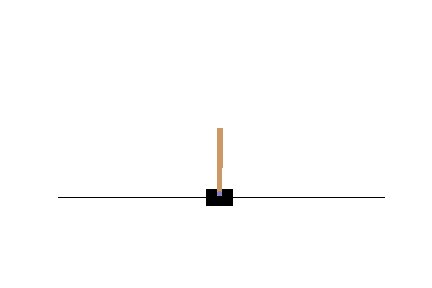
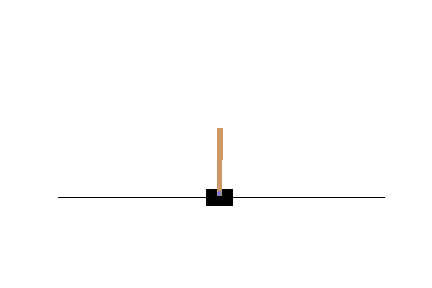
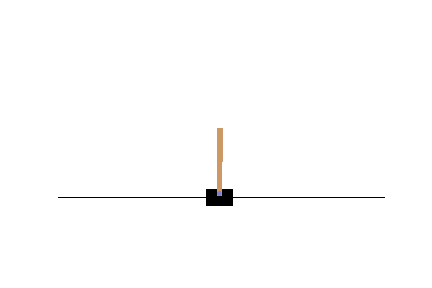
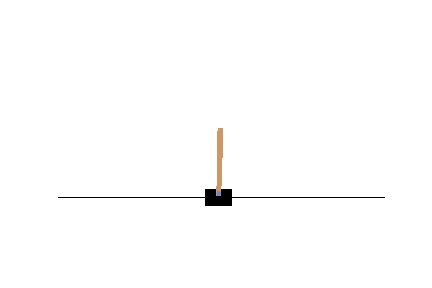
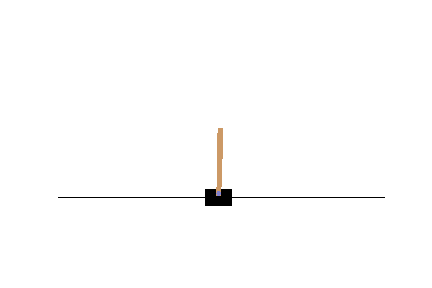
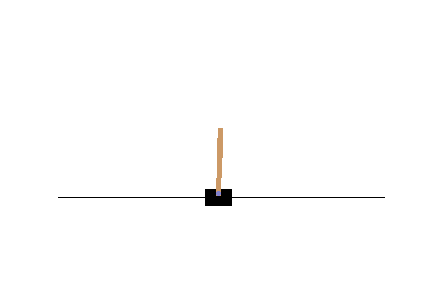
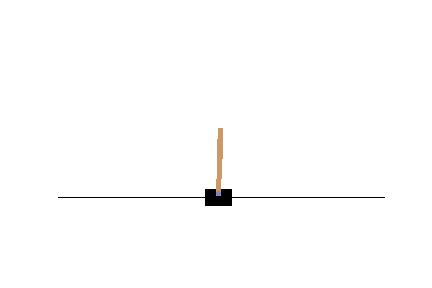
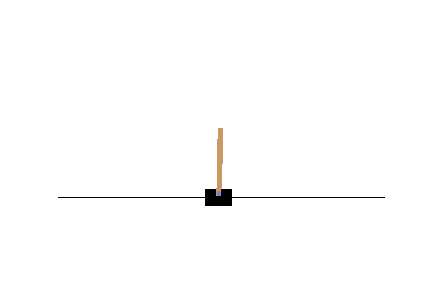
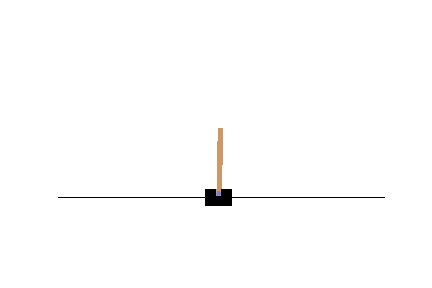
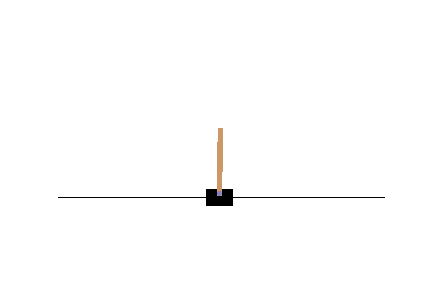
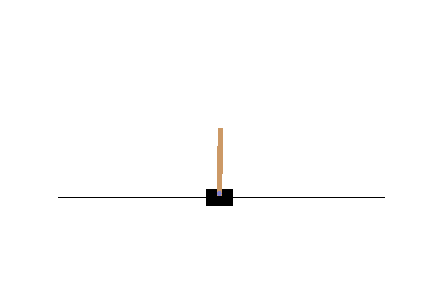
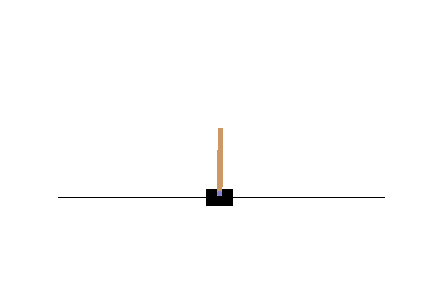
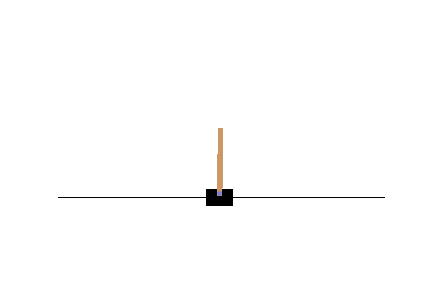
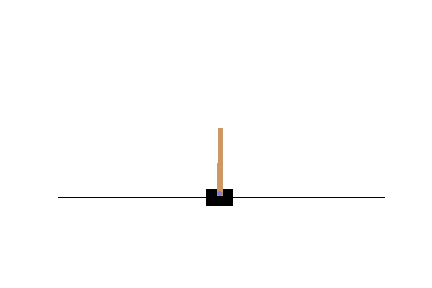
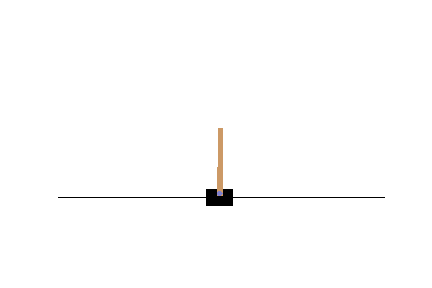
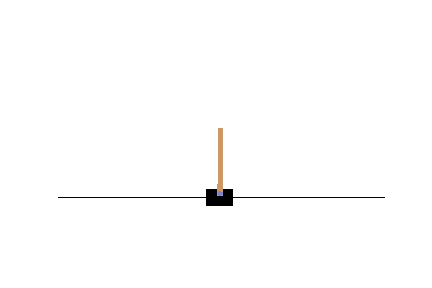
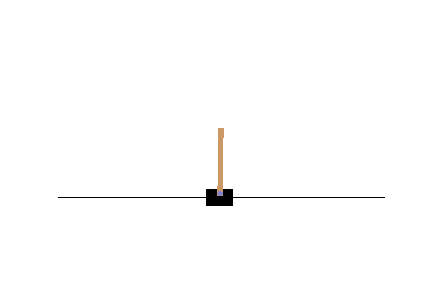
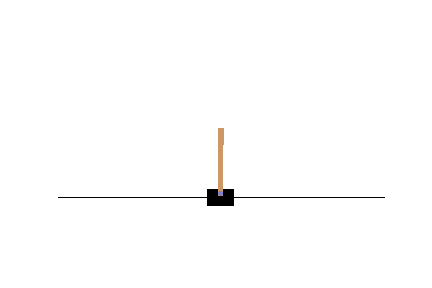
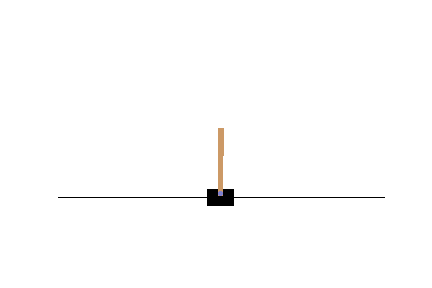
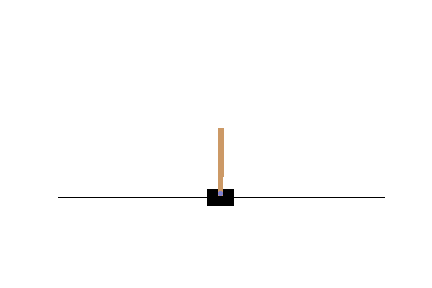
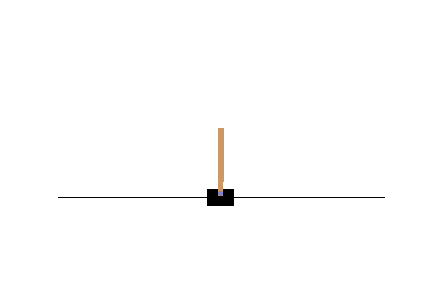
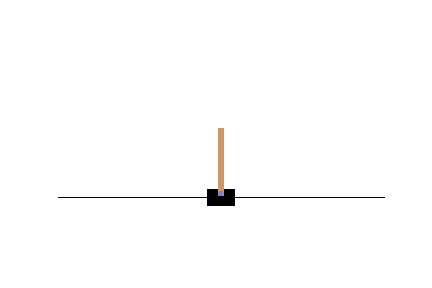
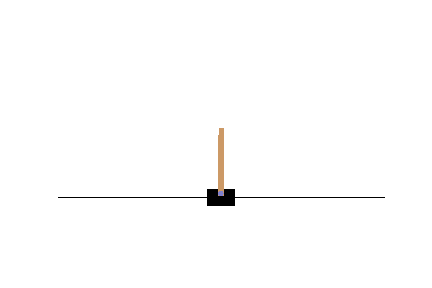
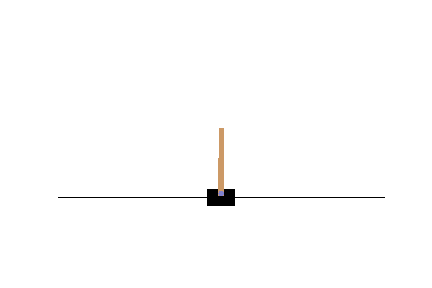
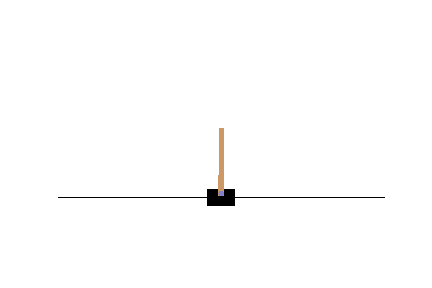
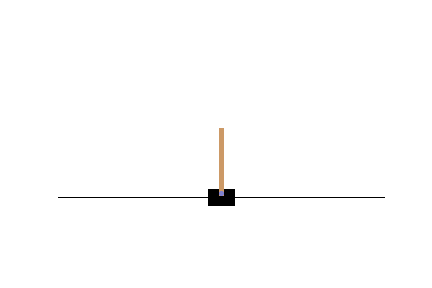
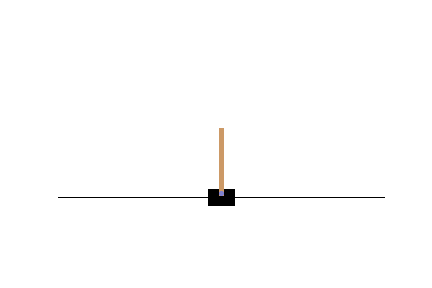
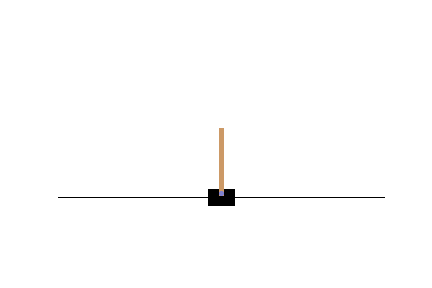
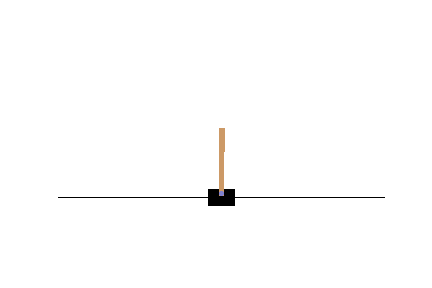
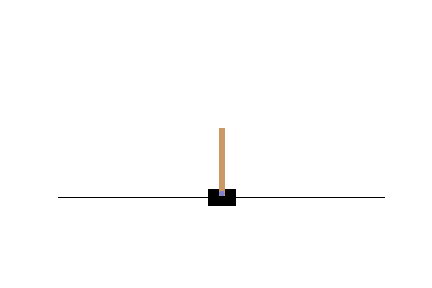
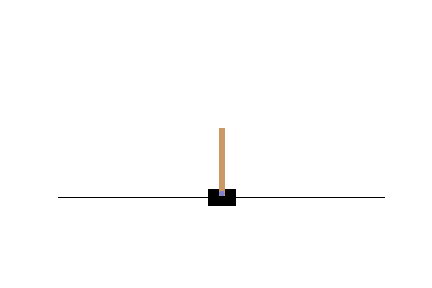
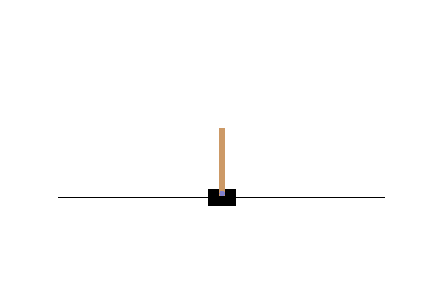
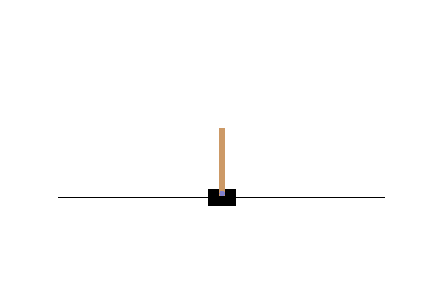
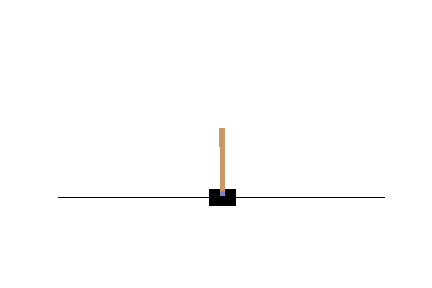
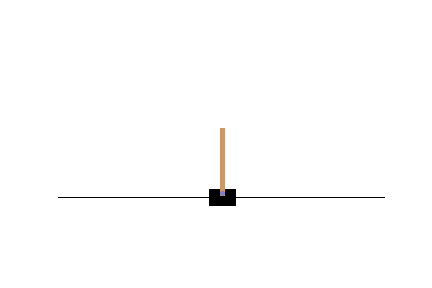
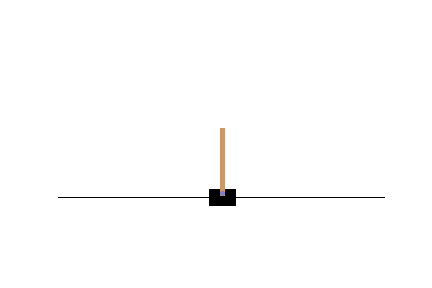
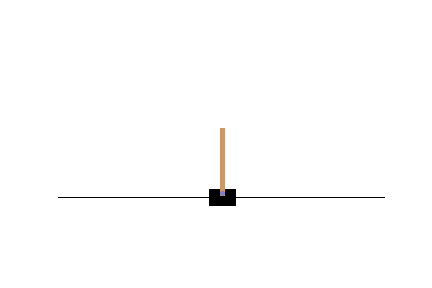
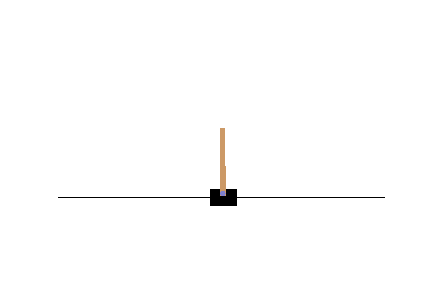
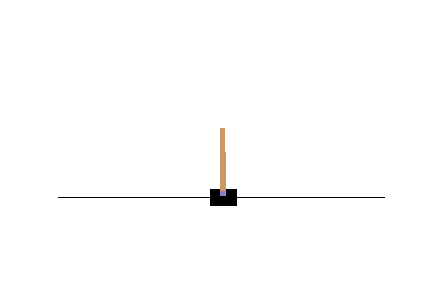
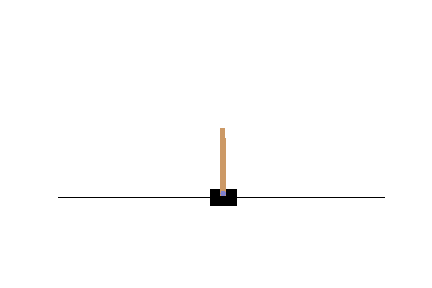
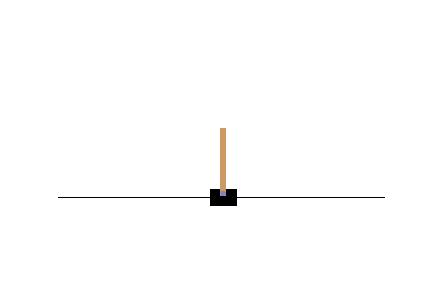
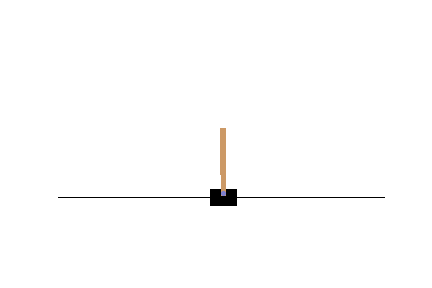
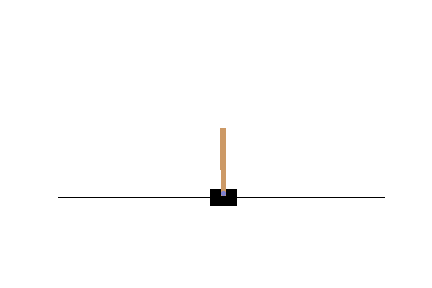
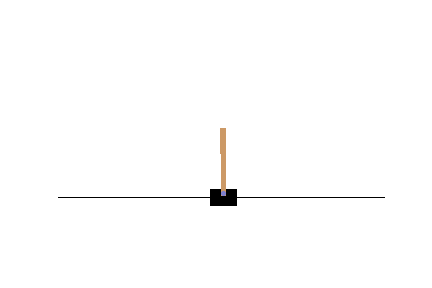
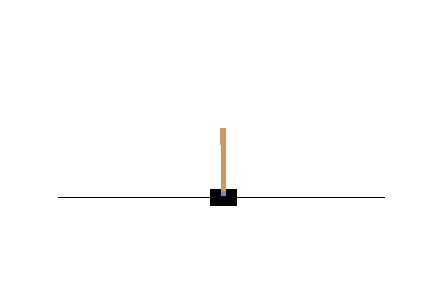
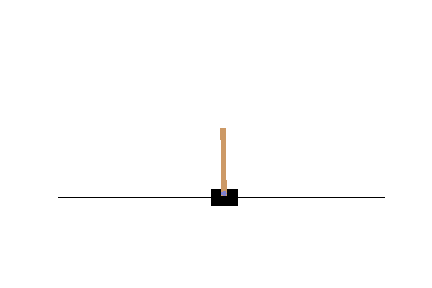
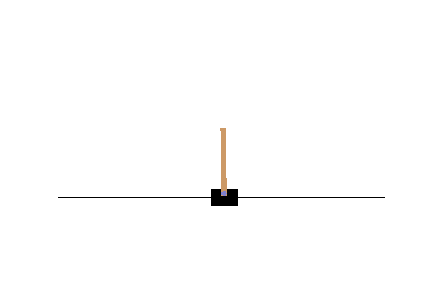
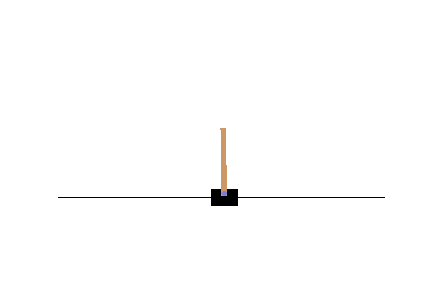
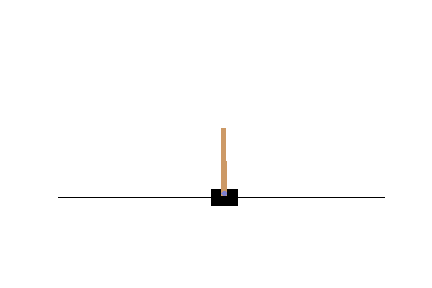
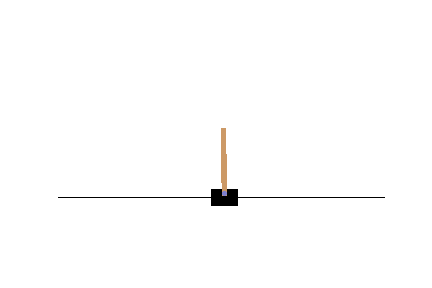
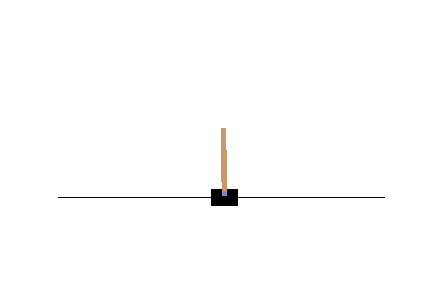
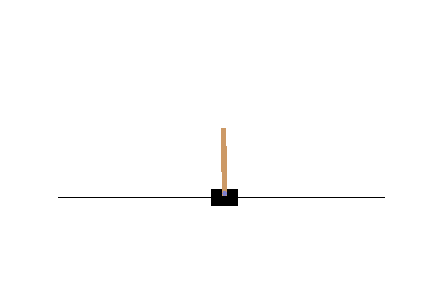
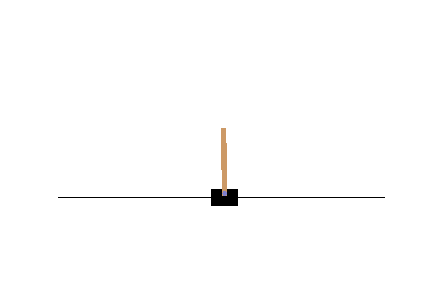
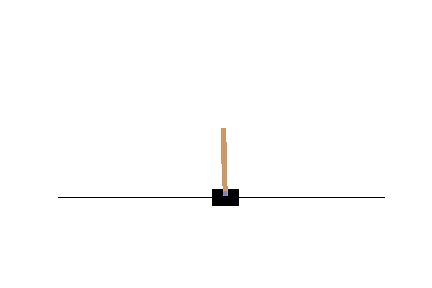
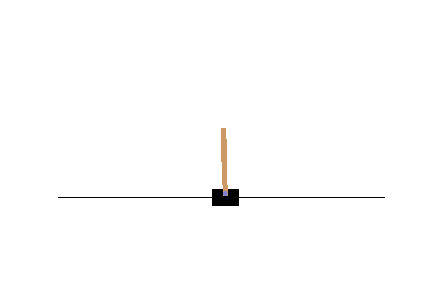
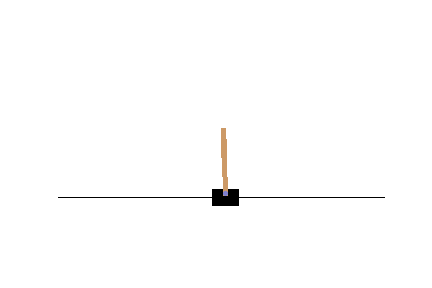
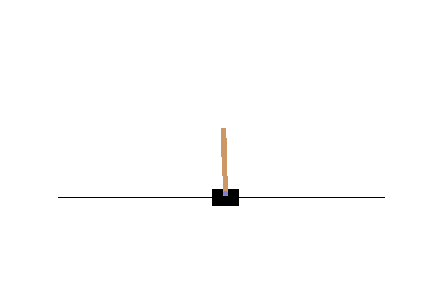
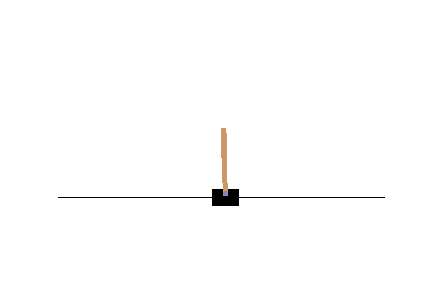
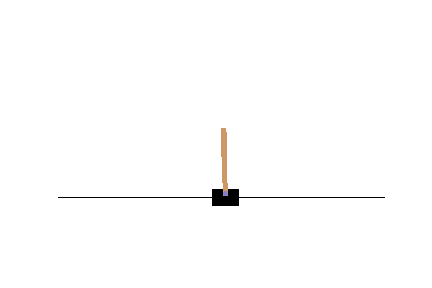
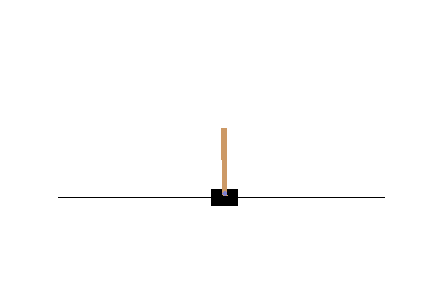
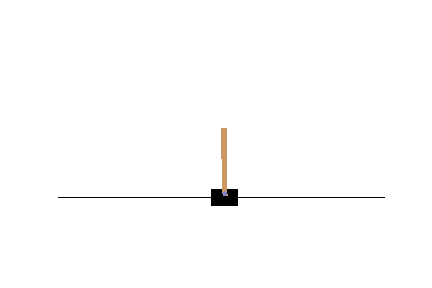
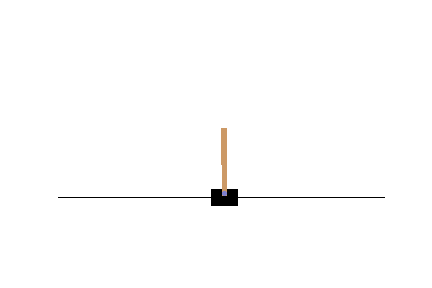
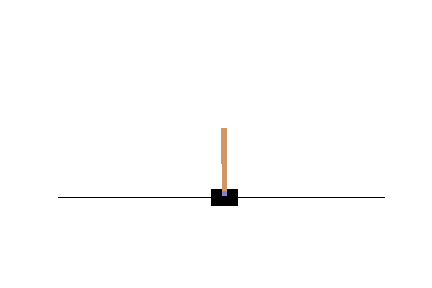
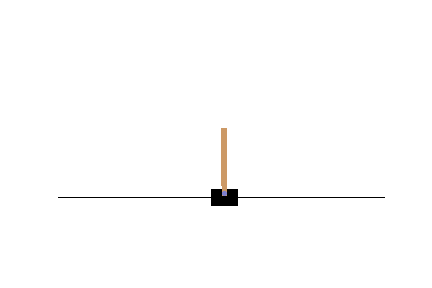
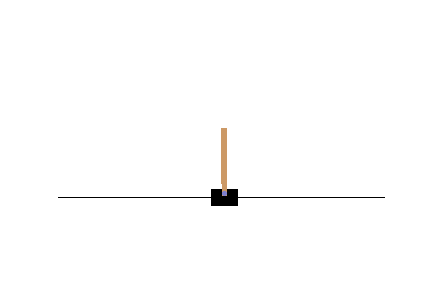
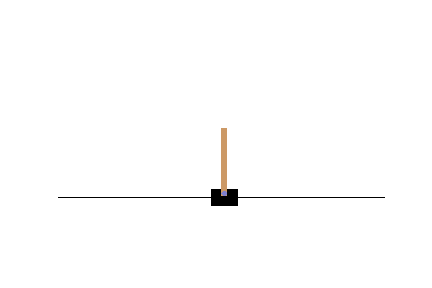
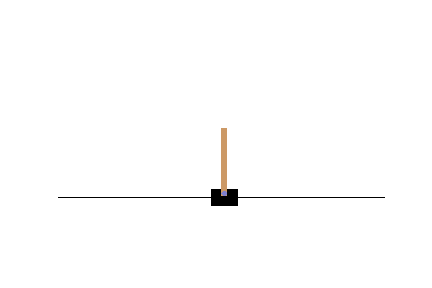
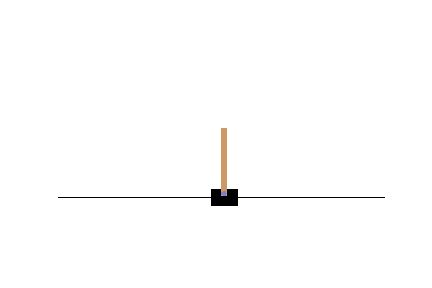
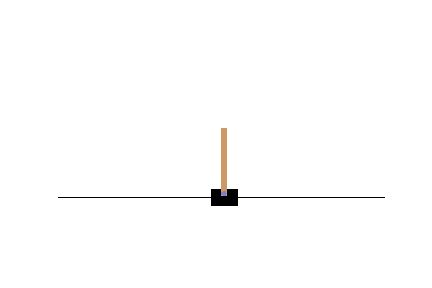
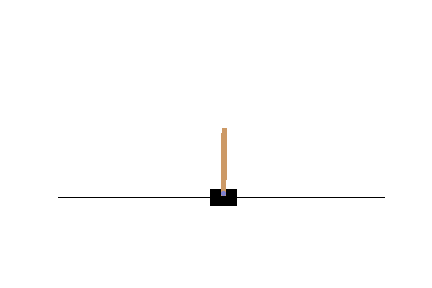
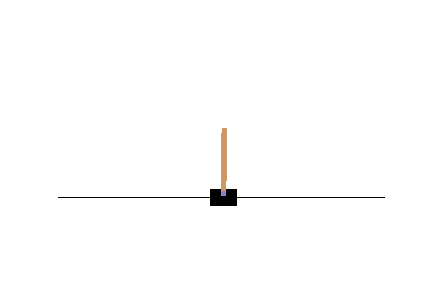
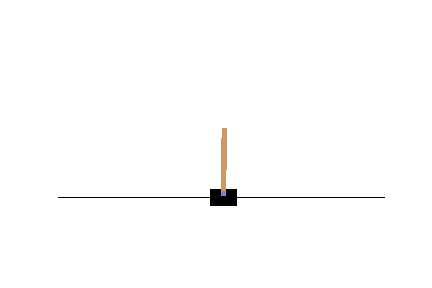
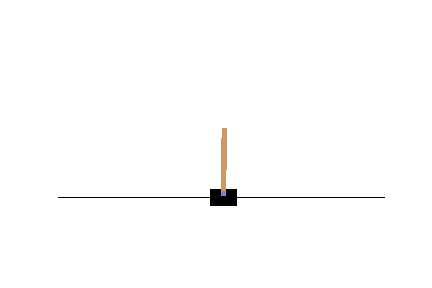
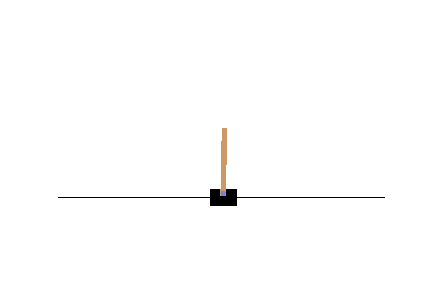
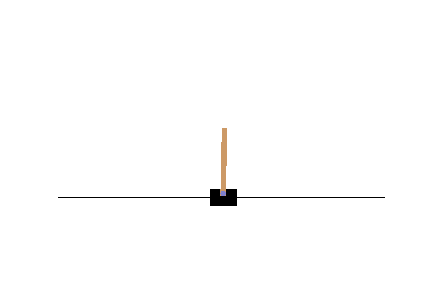
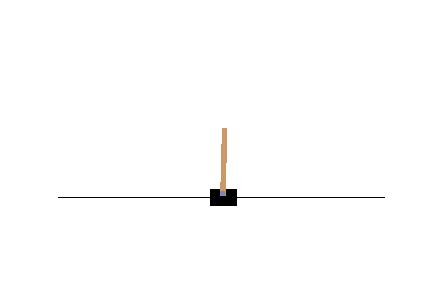
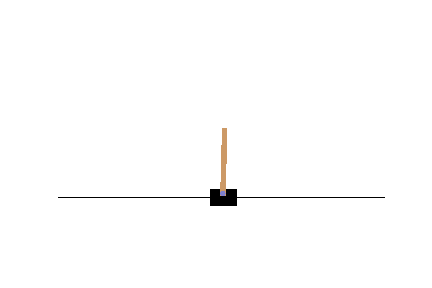
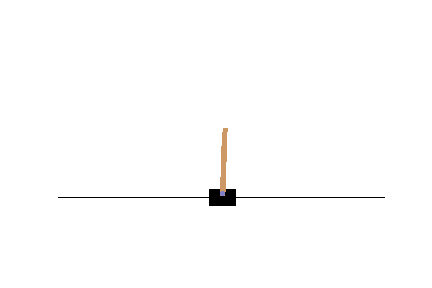
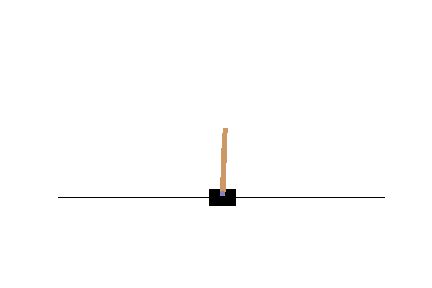
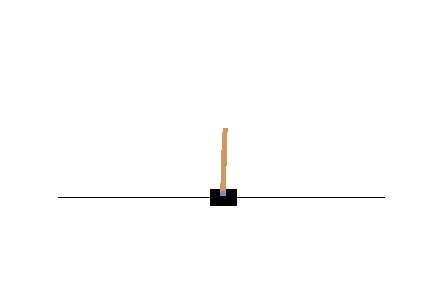
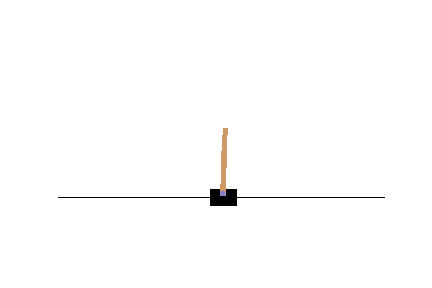
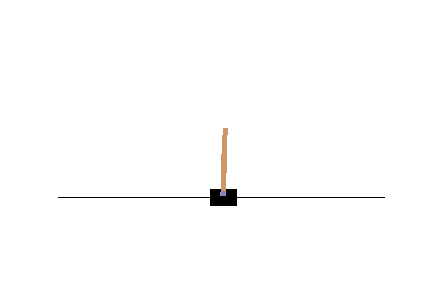
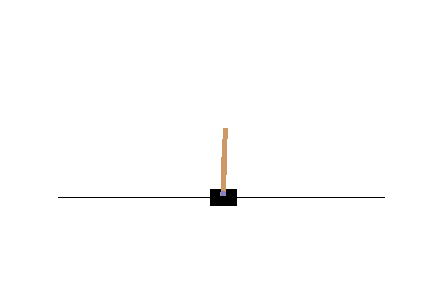
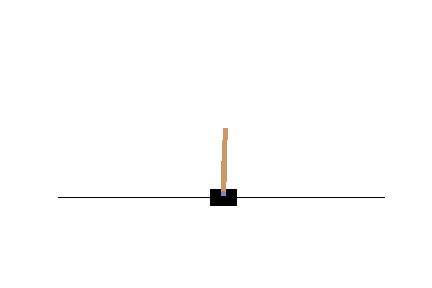
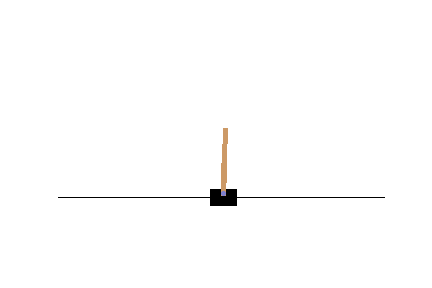
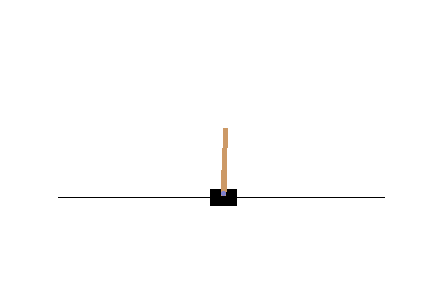
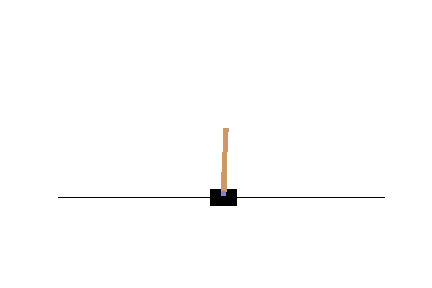
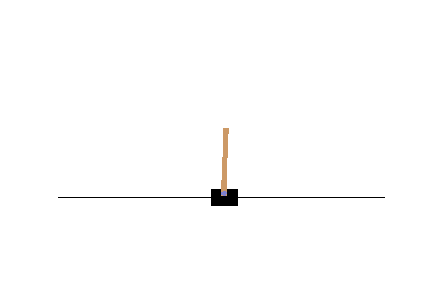
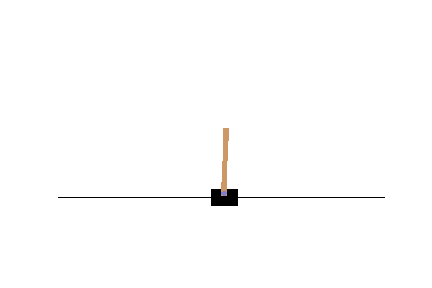
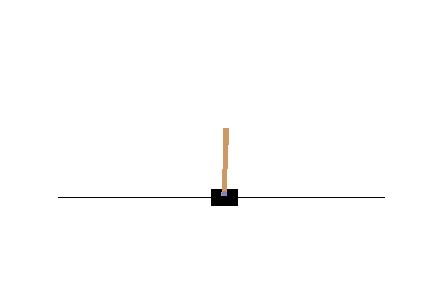
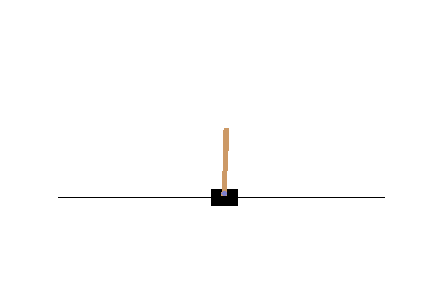
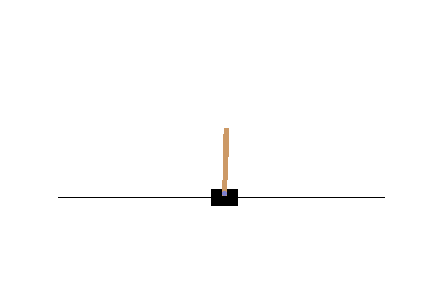
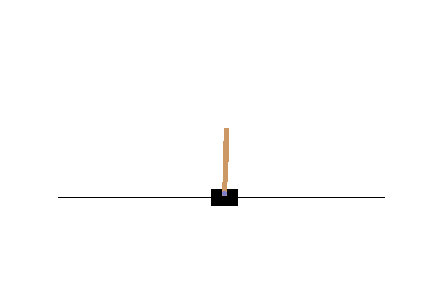
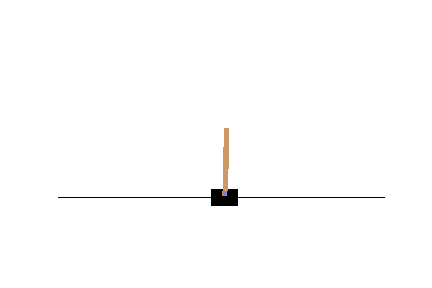
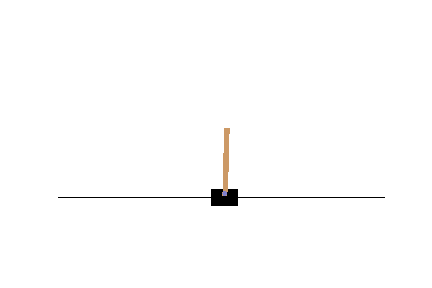
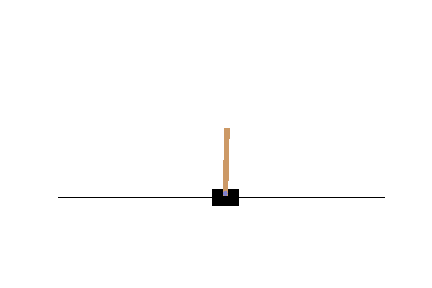
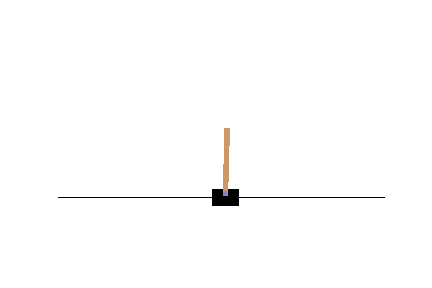
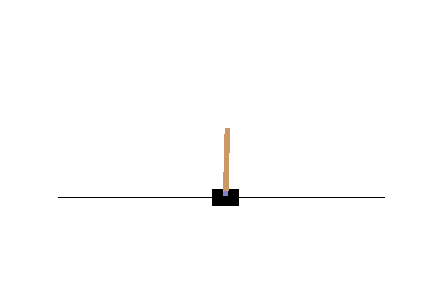
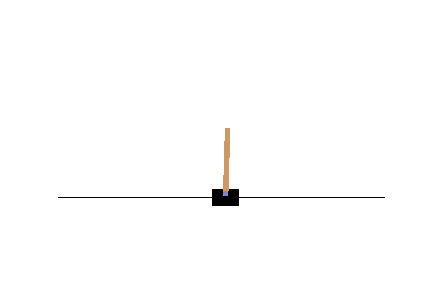
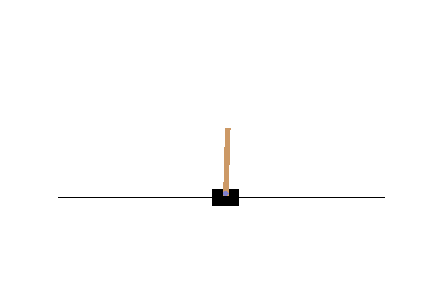
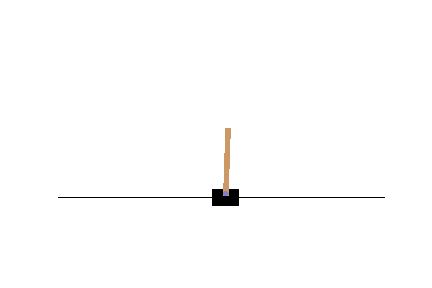
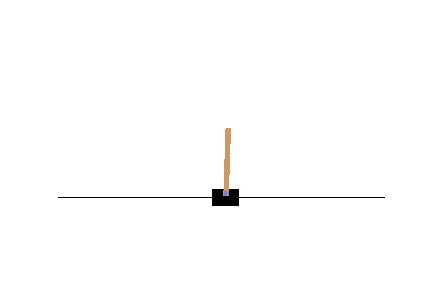
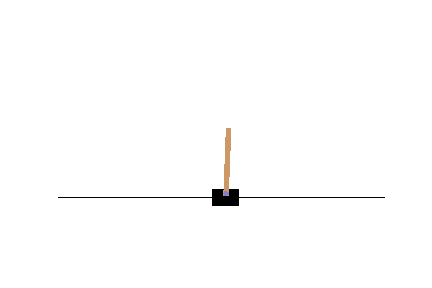
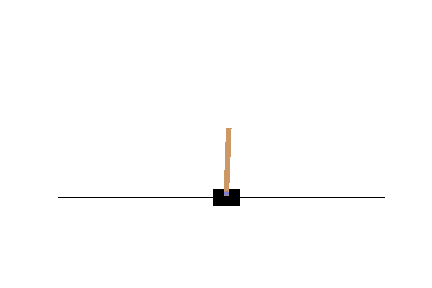
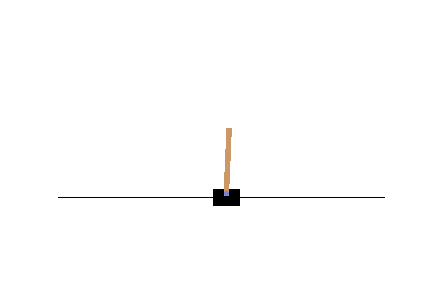
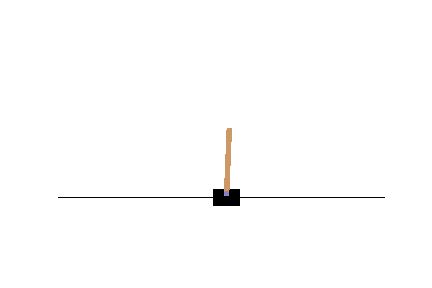
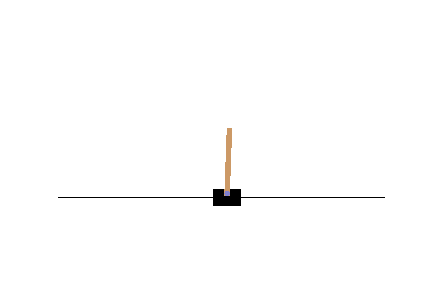
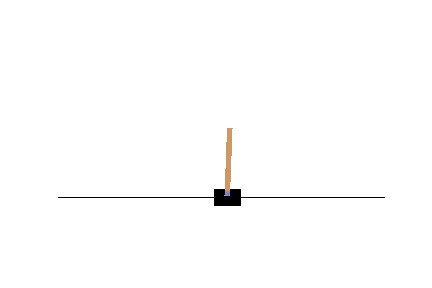
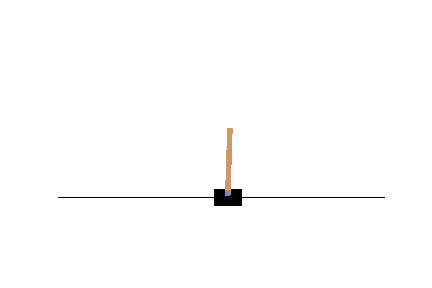
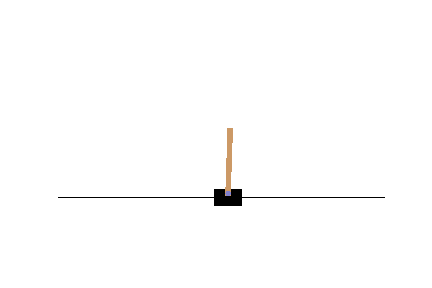
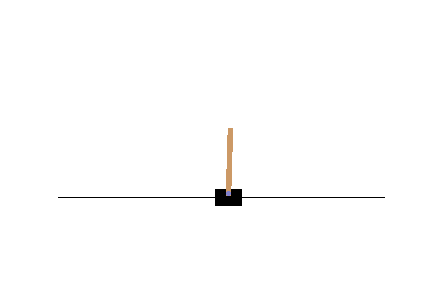
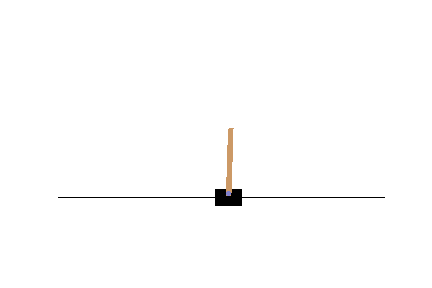
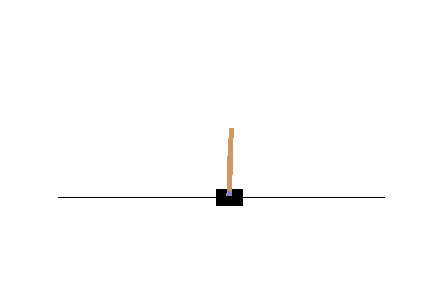
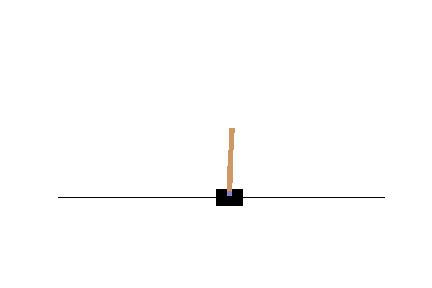
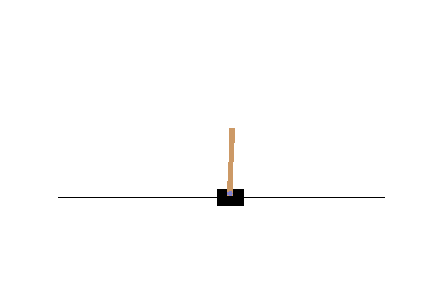
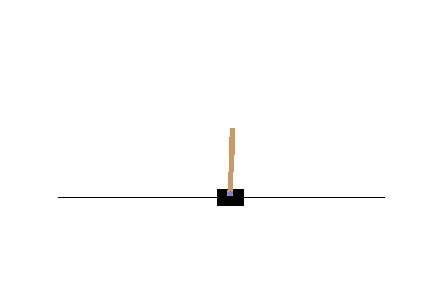
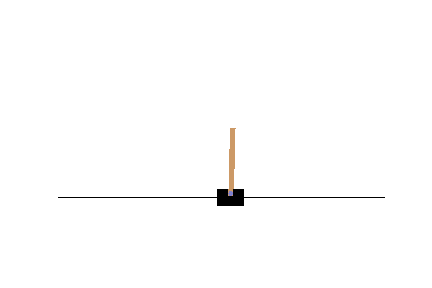
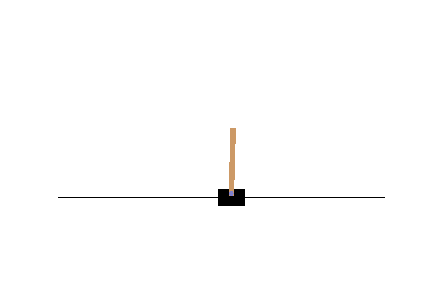
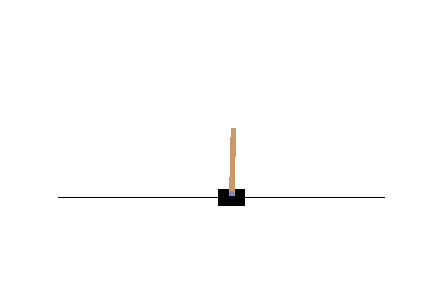
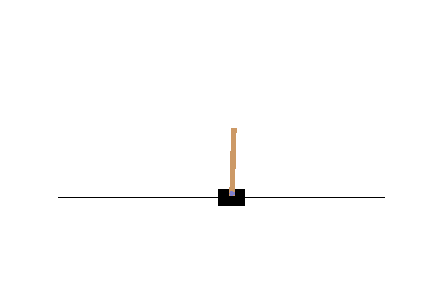
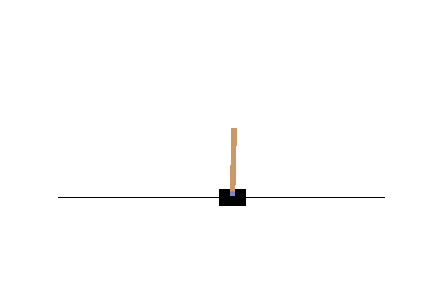
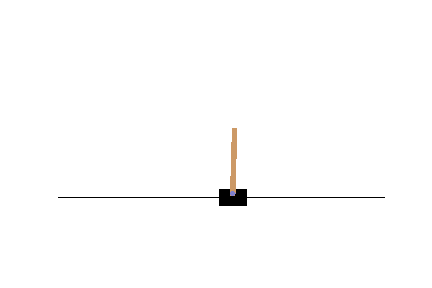
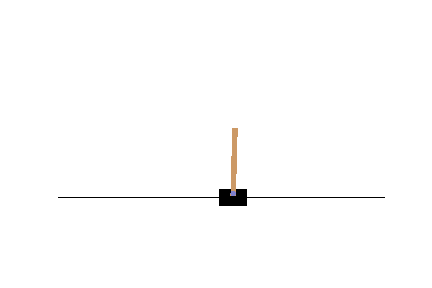
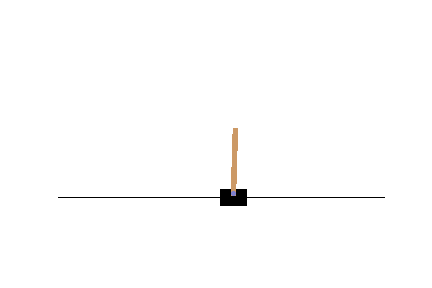
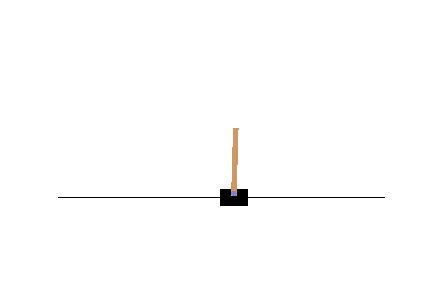
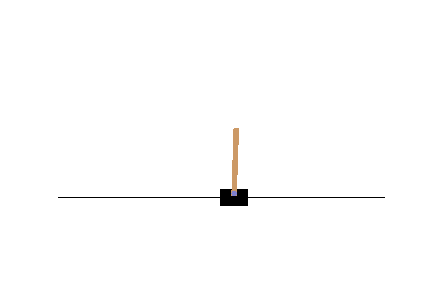
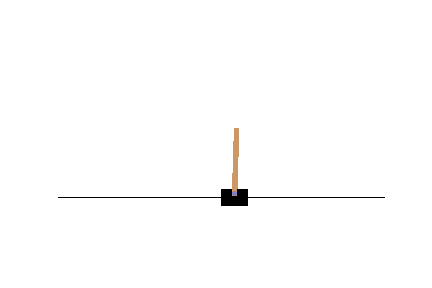
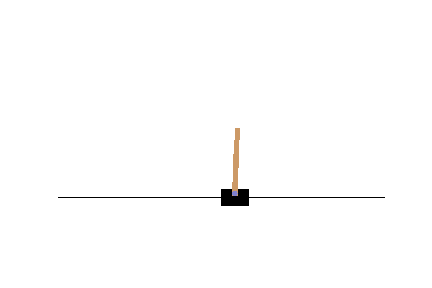
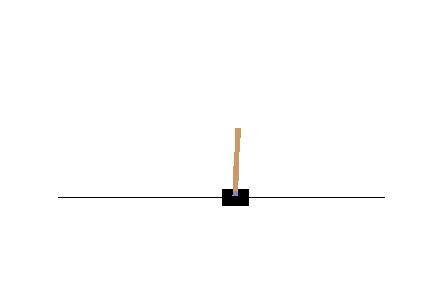
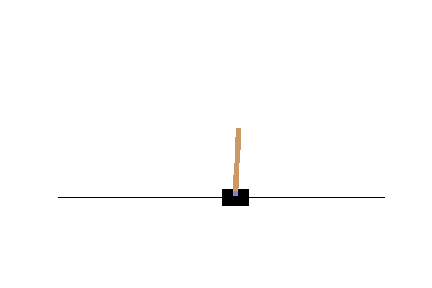
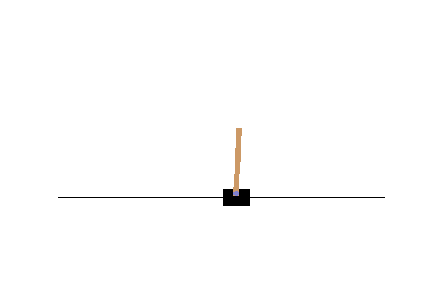
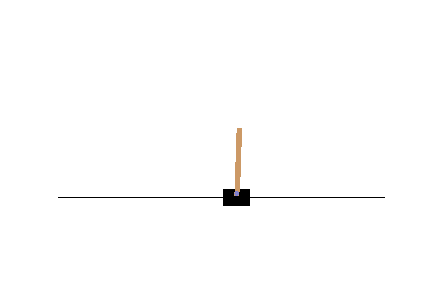
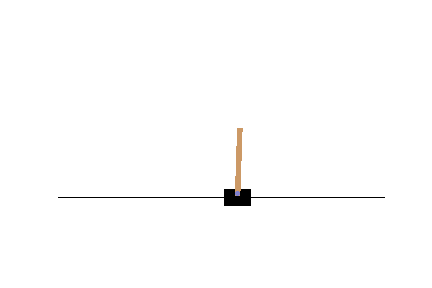
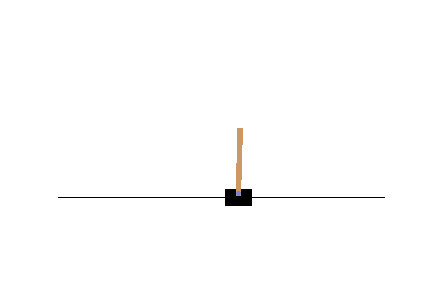
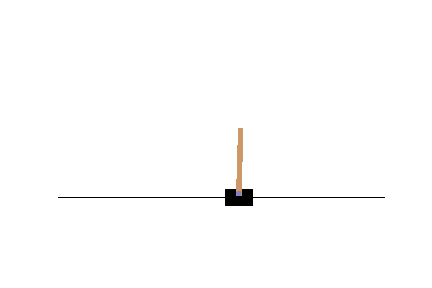
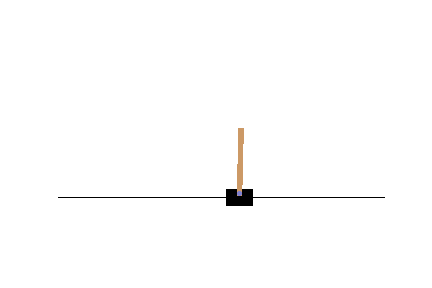
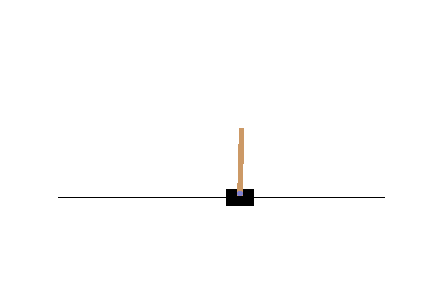
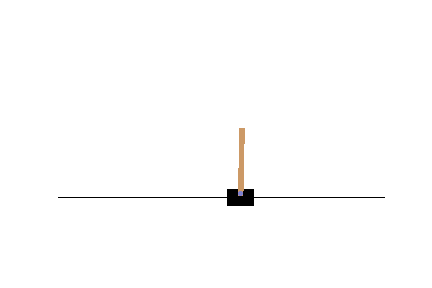
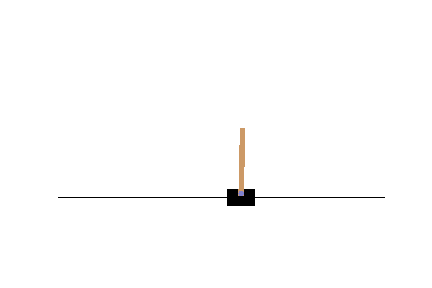
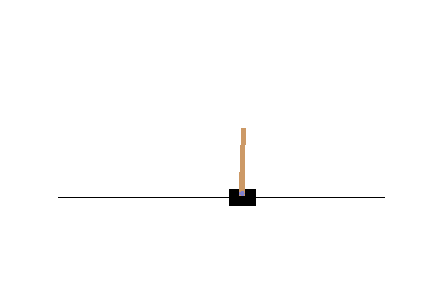
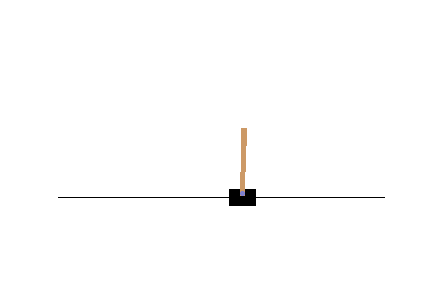
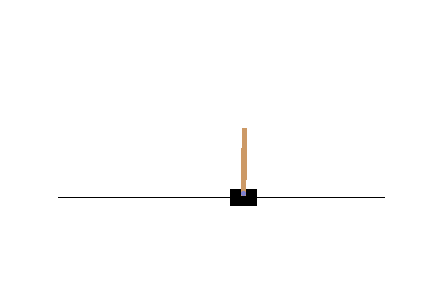
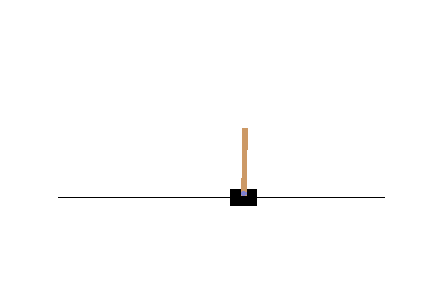
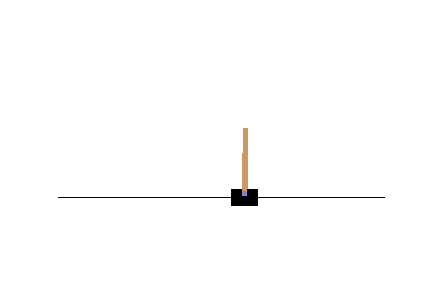
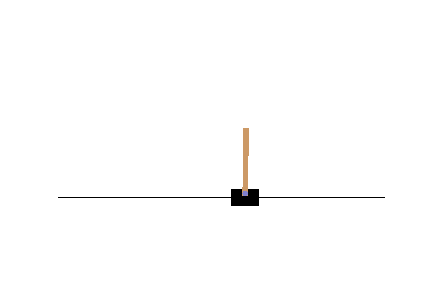
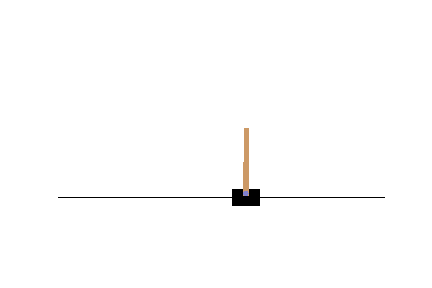
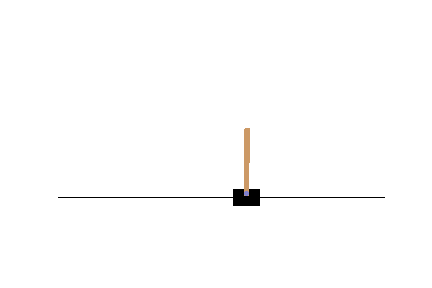
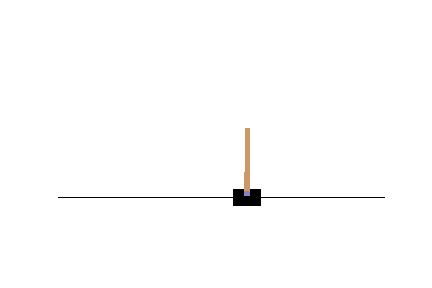
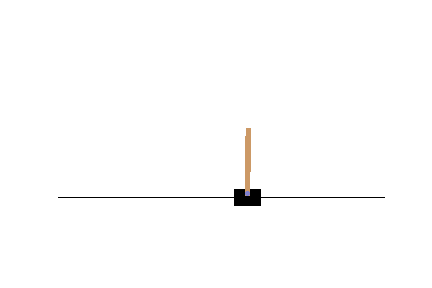
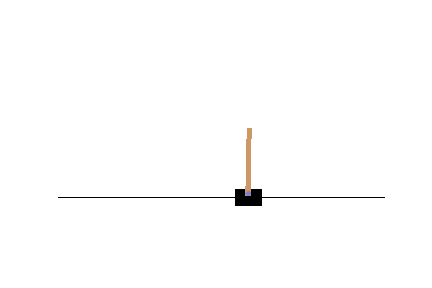
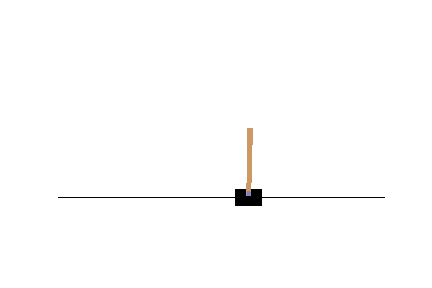
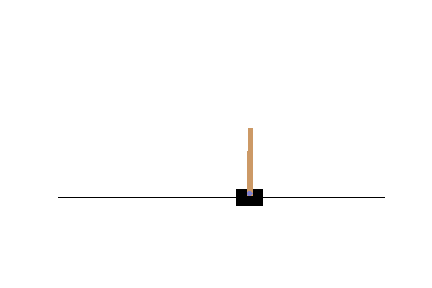
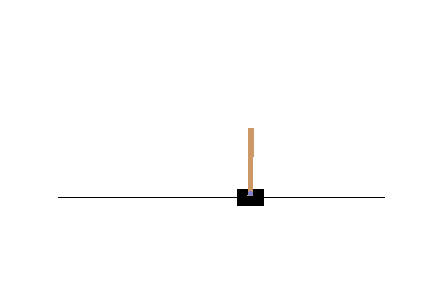
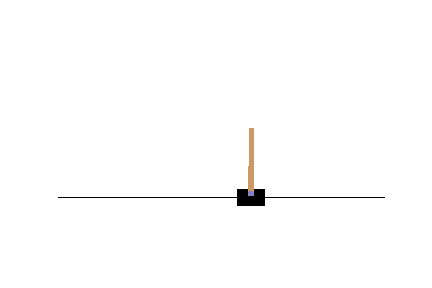
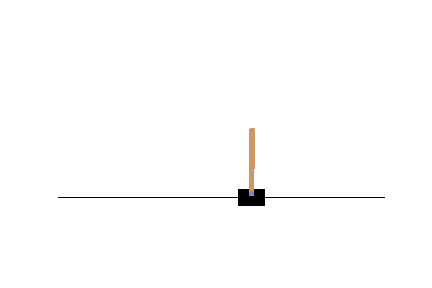
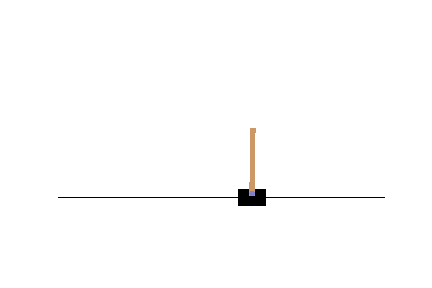
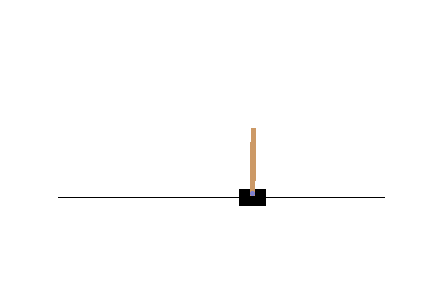
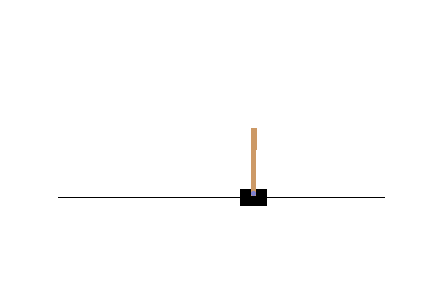
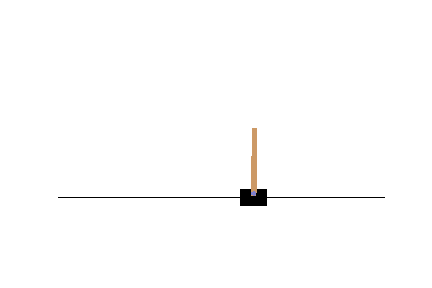
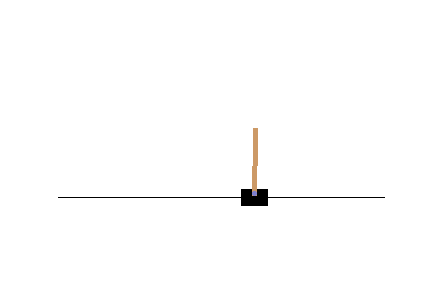
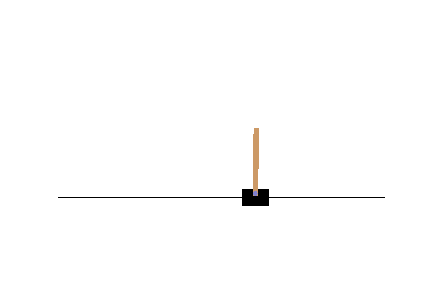
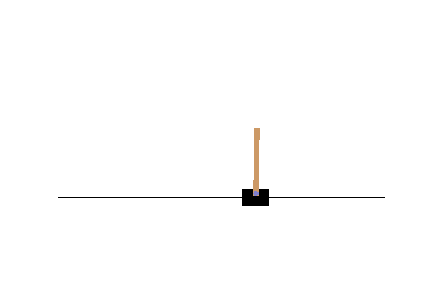
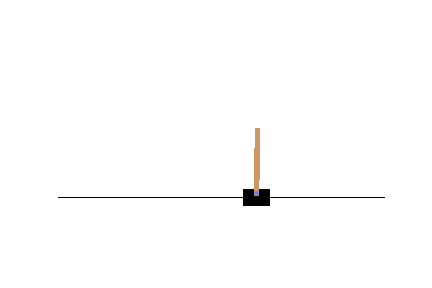
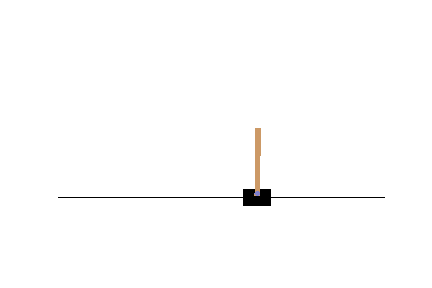
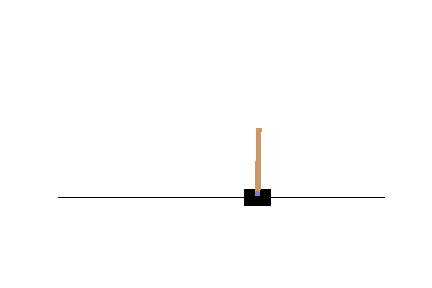
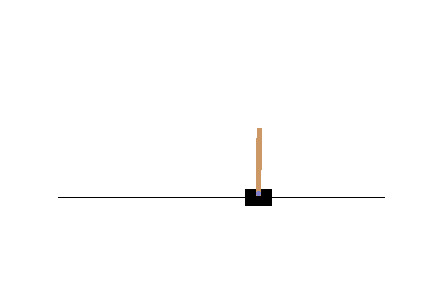
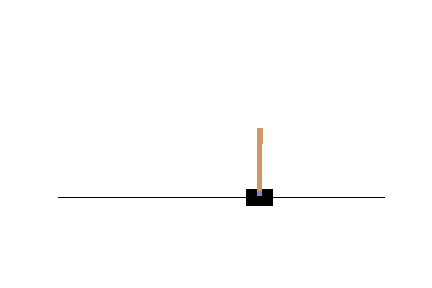
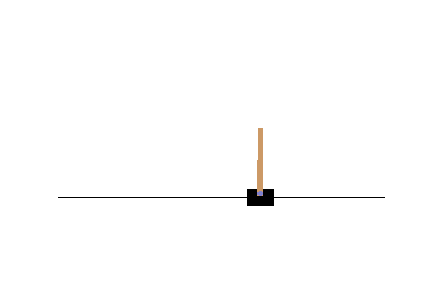
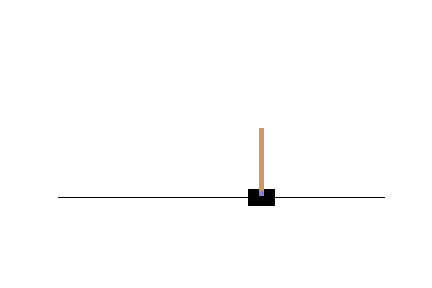
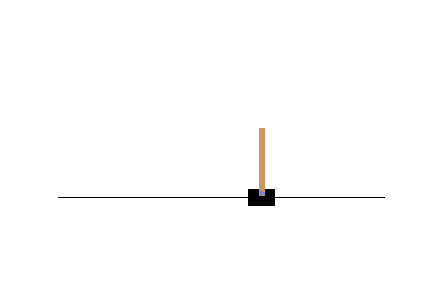
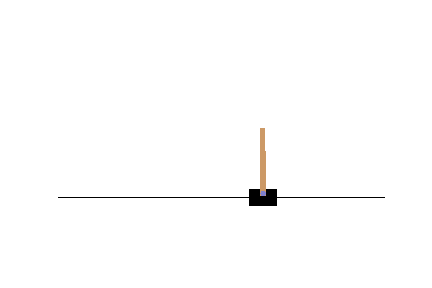
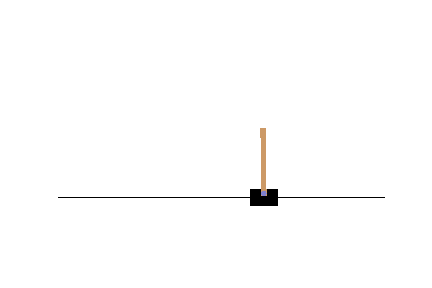
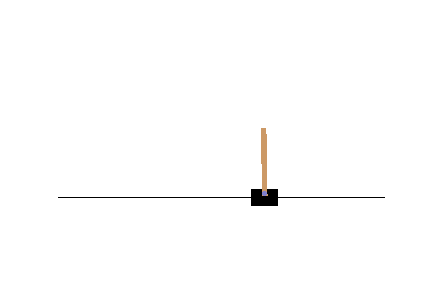
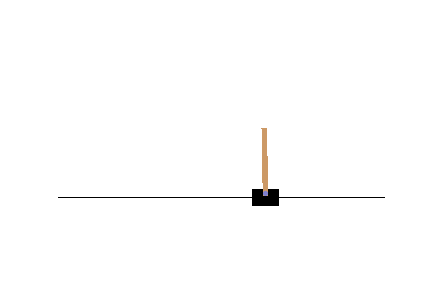
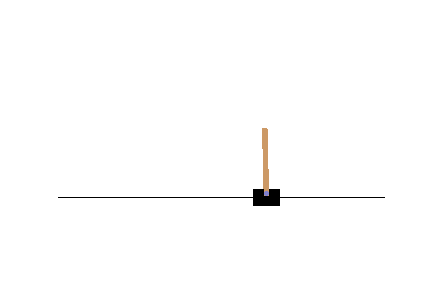
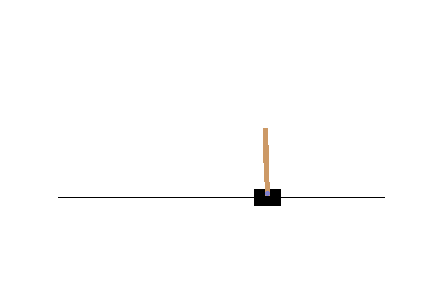

In [9]:
observation = env.reset()

frames = []
for episode in range(num_max_step):
    state = np.reshape(observation, [1, 4])
    action = get_action(state, episode, mainQN,  is_learning=False)
    observation, reward, done, _ =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

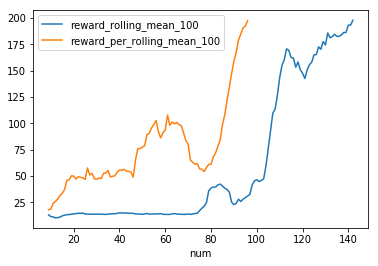

In [13]:
 # エピソード毎の獲得報酬を移動平均線で表示
df_rewards = pd.DataFrame({'num': range(0, len(rewards)), 'reward': rewards})
df_rewards_per = pd.DataFrame({'num': range(0, len(rewards_per)), 'reward_per': rewards_per})

df_rewards['reward_rolling_mean_100'] = df_rewards['reward'].rolling(window=10,center=False).mean()
df_rewards_per['reward_per_rolling_mean_100'] = df_rewards_per['reward_per'].rolling(window=10,center=False).mean()

ax = df_rewards.plot(kind='line', x='num', y='reward_rolling_mean_100')
df_rewards_per.plot(kind='line', x='num', y='reward_per_rolling_mean_100', ax=ax)